# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


# a. Training Function for Discriminator

In [4]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

# b. Training Function for Generator

In [5]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

# c. Monitors for Images and Losses


In [6]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(8, 3))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


# c. Model for Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels=[512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = None

        ##################
        ### Problem 1: Implement Discriminator
        ##################
        if with_condition:
            self.embedding = torch.nn.Embedding(10, 10)
            input_dim = 784 + 10
        else:
            input_dim = 784
        self.model = [
            nn.Linear(input_dim, channels[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        ]
        for i in range(len(channels) - 1):
            self.model += [
                nn.Linear(channels[i], channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout(0.2),
            ]
        self.model += [nn.Linear(channels[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
            label_embedding = self.embedding(label)
            x = torch.cat([x, label_embedding], dim=1)
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out


with torch.no_grad():
    discriminator = Discriminator(with_condition=True).to(device)
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)  # (128, 1, 28, 8)
        labels = labels.to(device)  # (128,)
        print(discriminator(images, labels).shape)
        break

torch.Size([128, 1])


# e. Model for Generator


In [8]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels=[128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = None
        ##################
        ### Problem 1: Implement Generator
        ##################
        if with_condition:
            self.embedding = torch.nn.Embedding(10, 10)
            input_dim = dim_z + 10
        else:
            input_dim = dim_z
        self.model = [nn.Linear(input_dim, channels[0]), nn.LeakyReLU()]
        for i in range(len(channels) - 1):
            self.model += [nn.Linear(channels[i], channels[i + 1]), nn.LeakyReLU()]
        self.model += [nn.Linear(channels[-1], 784), nn.Tanh()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
            label_embedding = self.embedding(label)
            x = torch.cat([x, label_embedding], dim=1)

        out = self.model(x)
        return out


with torch.no_grad():
    generator = Generator(with_condition=False).to(device)
    noise = Variable(torch.randn(batch_size, generator.dim_z)).to(device)
    print(generator(noise).shape)

torch.Size([128, 784])


# d. Training

In [9]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  dim_z = generator.dim_z
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device)) # (batch_size, 1, 28, 28)
          real_labels = Variable(torch.ones(images.size(0)).to(device)) # (batch_size, )
          cls_labels = cls_labels.to(device) # (batch_size, )

          # Sample from generator
          noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)
          fake_images = generator(noise, label=cls_labels if with_condition else None) # (batch_size, 784)
          fake_labels = Variable(torch.zeros(images.size(0)).to(device)) # (batch_size, )

          # Train the discriminator
          d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)

            # Sample again from the generator and get output from discriminator
            fake_images = generator(noise, label=cls_labels if with_condition else None)
            outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

            # Train the generator
            g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)



          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) % 100 == 0:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))
      if epoch in [0, 19] or (epoch+1) % 50 == 0:
        torch.save(discriminator.state_dict(), f'/workspace/CGAN_disc_epoch={epoch+1}.pt')
        torch.save(generator.state_dict(), f'/workspace/CGAN_gen_epoch={epoch+1}.pt')

      if epoch == 0 or (epoch+1) % 5 == 0:
        monitor_images(generator, test_noise, with_condition=with_condition)
        monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

In [ ]:
# set number of epochs and initialize figure counter
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)



In [ ]:
# I have pretrained 60 epochs. So the epochs of the results below are epoch + 60
num_epochs = 160
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# e. Ablation Study

In [ ]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################
# set number of epochs and initialize figure counter

# Ablation 1: Double the size of the channels in generator

dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(channels=np.array([128, 256, 512])*2, with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

num_epochs = 200
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# **2. Conditional GAN**

Epoch [1/200], Step[100/469], d_loss: 0.2355, d_loss_fake: 0.2104, g_loss: 1.9507, g_loss_fake: 0.1599, D(x): 0.98, D(G(z)): 0.19
Epoch [1/200], Step[200/469], d_loss: 0.1853, d_loss_fake: 0.1534, g_loss: 3.5046, g_loss_fake: 0.0552, D(x): 0.97, D(G(z)): 0.13
Epoch [1/200], Step[300/469], d_loss: 0.1432, d_loss_fake: 0.1232, g_loss: 4.5326, g_loss_fake: 0.0294, D(x): 0.98, D(G(z)): 0.11
Epoch [1/200], Step[400/469], d_loss: 0.1966, d_loss_fake: 0.1308, g_loss: 4.6703, g_loss_fake: 0.0384, D(x): 0.95, D(G(z)): 0.09


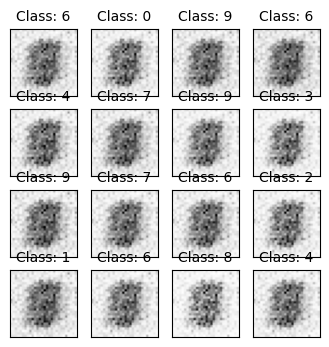

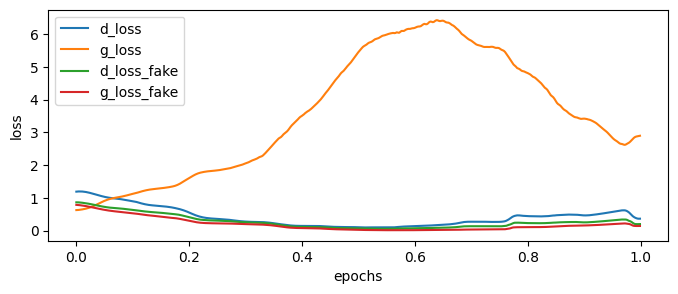

Epoch [2/200], Step[100/469], d_loss: 0.3259, d_loss_fake: 0.2453, g_loss: 2.8277, g_loss_fake: 0.1051, D(x): 0.94, D(G(z)): 0.20
Epoch [2/200], Step[200/469], d_loss: 0.0687, d_loss_fake: 0.0512, g_loss: 3.8585, g_loss_fake: 0.0317, D(x): 0.98, D(G(z)): 0.05
Epoch [2/200], Step[300/469], d_loss: 0.0461, d_loss_fake: 0.0383, g_loss: 6.6267, g_loss_fake: 0.0034, D(x): 0.99, D(G(z)): 0.03
Epoch [2/200], Step[400/469], d_loss: 0.1487, d_loss_fake: 0.0241, g_loss: 4.5026, g_loss_fake: 0.0313, D(x): 0.93, D(G(z)): 0.02
Epoch [3/200], Step[100/469], d_loss: 0.0516, d_loss_fake: 0.0274, g_loss: 5.9170, g_loss_fake: 0.0118, D(x): 0.98, D(G(z)): 0.02
Epoch [3/200], Step[200/469], d_loss: 0.0937, d_loss_fake: 0.0292, g_loss: 4.9873, g_loss_fake: 0.0289, D(x): 0.96, D(G(z)): 0.03
Epoch [3/200], Step[300/469], d_loss: 0.1037, d_loss_fake: 0.0294, g_loss: 4.4273, g_loss_fake: 0.0763, D(x): 0.96, D(G(z)): 0.03
Epoch [3/200], Step[400/469], d_loss: 0.1240, d_loss_fake: 0.0402, g_loss: 4.8432, g_loss_

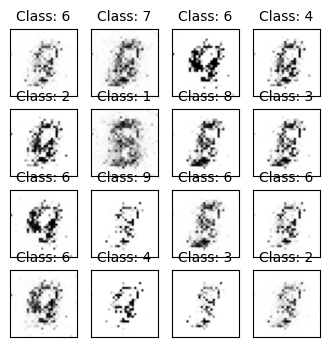

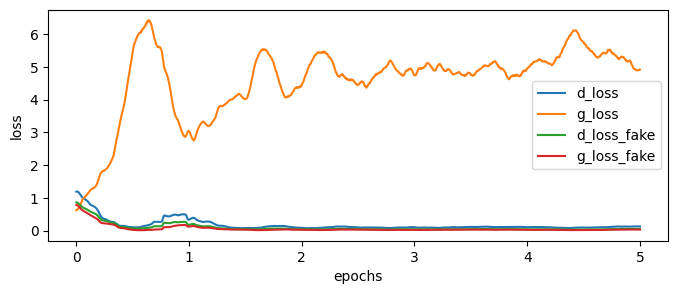

Epoch [6/200], Step[100/469], d_loss: 0.2480, d_loss_fake: 0.1289, g_loss: 3.5603, g_loss_fake: 0.0871, D(x): 0.94, D(G(z)): 0.10
Epoch [6/200], Step[200/469], d_loss: 0.0430, d_loss_fake: 0.0385, g_loss: 5.8105, g_loss_fake: 0.0112, D(x): 1.00, D(G(z)): 0.03
Epoch [6/200], Step[300/469], d_loss: 0.0835, d_loss_fake: 0.0197, g_loss: 5.7175, g_loss_fake: 0.0151, D(x): 0.97, D(G(z)): 0.02
Epoch [6/200], Step[400/469], d_loss: 0.2490, d_loss_fake: 0.1276, g_loss: 3.6925, g_loss_fake: 0.0509, D(x): 0.95, D(G(z)): 0.09
Epoch [7/200], Step[100/469], d_loss: 0.1571, d_loss_fake: 0.0814, g_loss: 4.9387, g_loss_fake: 0.0302, D(x): 0.96, D(G(z)): 0.06
Epoch [7/200], Step[200/469], d_loss: 0.1111, d_loss_fake: 0.0531, g_loss: 5.1799, g_loss_fake: 0.0250, D(x): 0.98, D(G(z)): 0.04
Epoch [7/200], Step[300/469], d_loss: 0.2866, d_loss_fake: 0.0326, g_loss: 4.5027, g_loss_fake: 0.0575, D(x): 0.91, D(G(z)): 0.03
Epoch [7/200], Step[400/469], d_loss: 0.2490, d_loss_fake: 0.0285, g_loss: 5.9863, g_loss_

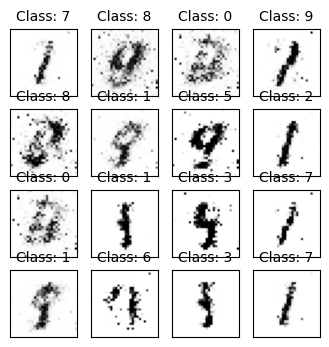

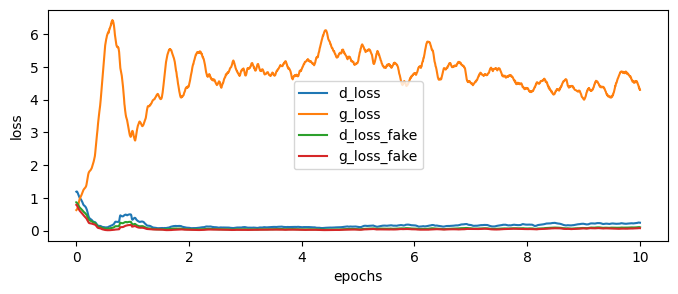

Epoch [11/200], Step[100/469], d_loss: 0.2190, d_loss_fake: 0.0737, g_loss: 5.5383, g_loss_fake: 0.0544, D(x): 0.93, D(G(z)): 0.05
Epoch [11/200], Step[200/469], d_loss: 0.2906, d_loss_fake: 0.0838, g_loss: 3.1559, g_loss_fake: 0.2302, D(x): 0.90, D(G(z)): 0.07
Epoch [11/200], Step[300/469], d_loss: 0.4194, d_loss_fake: 0.2171, g_loss: 4.5596, g_loss_fake: 0.0256, D(x): 0.92, D(G(z)): 0.11
Epoch [11/200], Step[400/469], d_loss: 0.3594, d_loss_fake: 0.1035, g_loss: 4.0176, g_loss_fake: 0.0373, D(x): 0.90, D(G(z)): 0.07
Epoch [12/200], Step[100/469], d_loss: 0.2942, d_loss_fake: 0.1530, g_loss: 5.1695, g_loss_fake: 0.0349, D(x): 0.94, D(G(z)): 0.09
Epoch [12/200], Step[200/469], d_loss: 0.4184, d_loss_fake: 0.1050, g_loss: 3.7652, g_loss_fake: 0.1786, D(x): 0.89, D(G(z)): 0.08
Epoch [12/200], Step[300/469], d_loss: 0.2486, d_loss_fake: 0.0656, g_loss: 3.6564, g_loss_fake: 0.0722, D(x): 0.90, D(G(z)): 0.06
Epoch [12/200], Step[400/469], d_loss: 0.3124, d_loss_fake: 0.1264, g_loss: 4.0739,

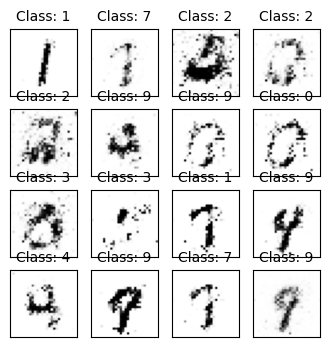

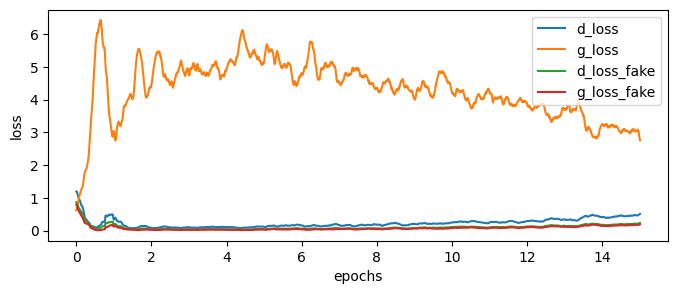

Epoch [16/200], Step[100/469], d_loss: 0.3602, d_loss_fake: 0.0958, g_loss: 3.0155, g_loss_fake: 0.1242, D(x): 0.87, D(G(z)): 0.08
Epoch [16/200], Step[200/469], d_loss: 0.5522, d_loss_fake: 0.3187, g_loss: 2.5724, g_loss_fake: 0.2082, D(x): 0.86, D(G(z)): 0.19
Epoch [16/200], Step[300/469], d_loss: 0.4805, d_loss_fake: 0.2012, g_loss: 2.5376, g_loss_fake: 0.2148, D(x): 0.82, D(G(z)): 0.16
Epoch [16/200], Step[400/469], d_loss: 0.3693, d_loss_fake: 0.2190, g_loss: 3.4779, g_loss_fake: 0.0917, D(x): 0.92, D(G(z)): 0.15
Epoch [17/200], Step[100/469], d_loss: 0.3297, d_loss_fake: 0.1408, g_loss: 3.8035, g_loss_fake: 0.0917, D(x): 0.89, D(G(z)): 0.09
Epoch [17/200], Step[200/469], d_loss: 0.7112, d_loss_fake: 0.2711, g_loss: 2.7775, g_loss_fake: 0.1647, D(x): 0.79, D(G(z)): 0.16
Epoch [17/200], Step[300/469], d_loss: 0.5111, d_loss_fake: 0.0853, g_loss: 3.3152, g_loss_fake: 0.1470, D(x): 0.82, D(G(z)): 0.06
Epoch [17/200], Step[400/469], d_loss: 0.5187, d_loss_fake: 0.2733, g_loss: 3.0964,

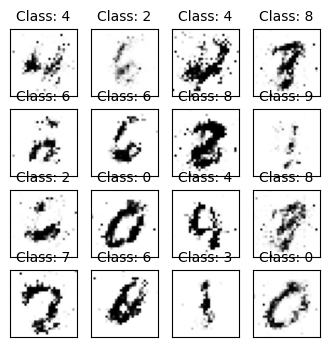

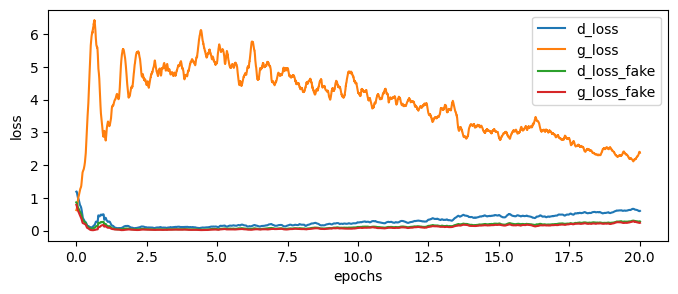

Epoch [21/200], Step[100/469], d_loss: 0.6013, d_loss_fake: 0.2350, g_loss: 1.9164, g_loss_fake: 0.2883, D(x): 0.79, D(G(z)): 0.18
Epoch [21/200], Step[200/469], d_loss: 0.5957, d_loss_fake: 0.1219, g_loss: 2.4324, g_loss_fake: 0.2120, D(x): 0.74, D(G(z)): 0.11
Epoch [21/200], Step[300/469], d_loss: 0.6513, d_loss_fake: 0.2674, g_loss: 2.2590, g_loss_fake: 0.2657, D(x): 0.77, D(G(z)): 0.19
Epoch [21/200], Step[400/469], d_loss: 0.6287, d_loss_fake: 0.2577, g_loss: 2.1815, g_loss_fake: 0.2907, D(x): 0.80, D(G(z)): 0.18
Epoch [22/200], Step[100/469], d_loss: 0.6064, d_loss_fake: 0.2034, g_loss: 2.3451, g_loss_fake: 0.2191, D(x): 0.77, D(G(z)): 0.15
Epoch [22/200], Step[200/469], d_loss: 0.5633, d_loss_fake: 0.3543, g_loss: 2.1368, g_loss_fake: 0.3015, D(x): 0.86, D(G(z)): 0.24
Epoch [22/200], Step[300/469], d_loss: 0.7988, d_loss_fake: 0.4006, g_loss: 2.1504, g_loss_fake: 0.2333, D(x): 0.77, D(G(z)): 0.25
Epoch [22/200], Step[400/469], d_loss: 0.7924, d_loss_fake: 0.2649, g_loss: 2.0418,

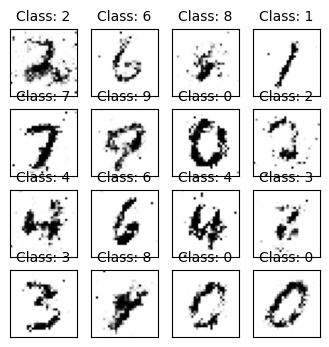

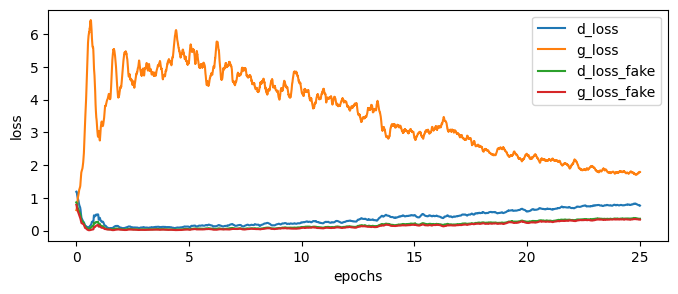

Epoch [26/200], Step[100/469], d_loss: 0.7594, d_loss_fake: 0.4138, g_loss: 1.7336, g_loss_fake: 0.3269, D(x): 0.78, D(G(z)): 0.27
Epoch [26/200], Step[200/469], d_loss: 0.8084, d_loss_fake: 0.3412, g_loss: 2.0123, g_loss_fake: 0.3238, D(x): 0.74, D(G(z)): 0.24
Epoch [26/200], Step[300/469], d_loss: 0.8409, d_loss_fake: 0.2811, g_loss: 1.7204, g_loss_fake: 0.3054, D(x): 0.67, D(G(z)): 0.21
Epoch [26/200], Step[400/469], d_loss: 0.8157, d_loss_fake: 0.3231, g_loss: 2.0146, g_loss_fake: 0.2789, D(x): 0.70, D(G(z)): 0.23
Epoch [27/200], Step[100/469], d_loss: 0.8360, d_loss_fake: 0.3773, g_loss: 1.6998, g_loss_fake: 0.3210, D(x): 0.72, D(G(z)): 0.28
Epoch [27/200], Step[200/469], d_loss: 0.8902, d_loss_fake: 0.4131, g_loss: 2.0107, g_loss_fake: 0.2785, D(x): 0.73, D(G(z)): 0.27
Epoch [27/200], Step[300/469], d_loss: 0.7953, d_loss_fake: 0.3630, g_loss: 1.8880, g_loss_fake: 0.2848, D(x): 0.73, D(G(z)): 0.25
Epoch [27/200], Step[400/469], d_loss: 0.8042, d_loss_fake: 0.3497, g_loss: 1.6427,

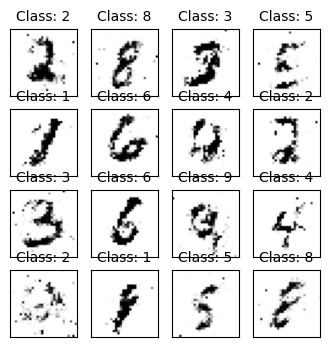

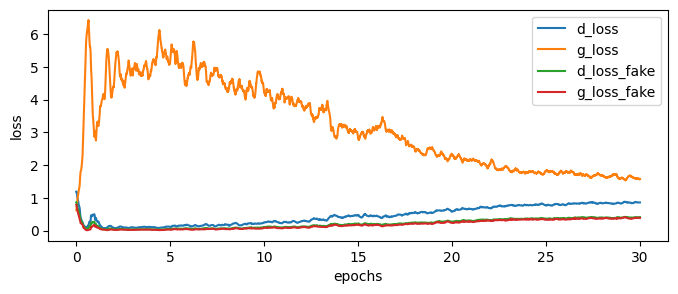

Epoch [31/200], Step[100/469], d_loss: 0.8734, d_loss_fake: 0.5214, g_loss: 1.3245, g_loss_fake: 0.4511, D(x): 0.76, D(G(z)): 0.35
Epoch [31/200], Step[200/469], d_loss: 0.9449, d_loss_fake: 0.4608, g_loss: 1.4654, g_loss_fake: 0.4027, D(x): 0.71, D(G(z)): 0.31
Epoch [31/200], Step[300/469], d_loss: 0.8040, d_loss_fake: 0.3674, g_loss: 1.7406, g_loss_fake: 0.3220, D(x): 0.72, D(G(z)): 0.27
Epoch [31/200], Step[400/469], d_loss: 0.7805, d_loss_fake: 0.3936, g_loss: 1.6750, g_loss_fake: 0.4571, D(x): 0.76, D(G(z)): 0.28
Epoch [32/200], Step[100/469], d_loss: 0.9300, d_loss_fake: 0.5583, g_loss: 1.6623, g_loss_fake: 0.3705, D(x): 0.78, D(G(z)): 0.35
Epoch [32/200], Step[200/469], d_loss: 0.9506, d_loss_fake: 0.4126, g_loss: 1.5765, g_loss_fake: 0.3794, D(x): 0.67, D(G(z)): 0.29
Epoch [32/200], Step[300/469], d_loss: 0.9874, d_loss_fake: 0.3896, g_loss: 1.5411, g_loss_fake: 0.3518, D(x): 0.65, D(G(z)): 0.27
Epoch [32/200], Step[400/469], d_loss: 0.9712, d_loss_fake: 0.4232, g_loss: 1.6726,

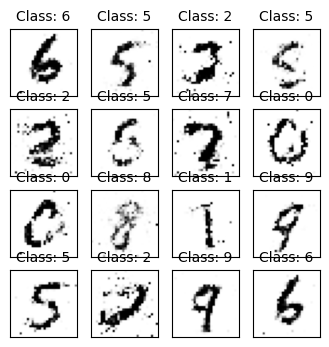

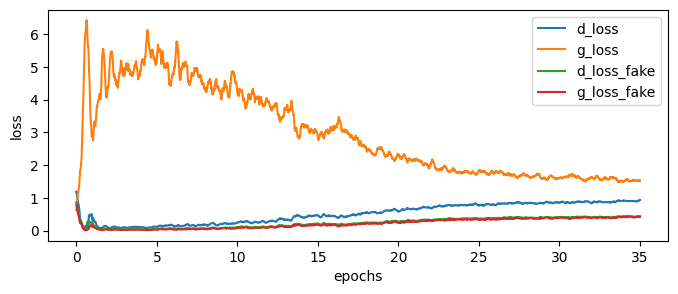

Epoch [36/200], Step[100/469], d_loss: 1.0127, d_loss_fake: 0.5617, g_loss: 1.3690, g_loss_fake: 0.4284, D(x): 0.71, D(G(z)): 0.37
Epoch [36/200], Step[200/469], d_loss: 0.8755, d_loss_fake: 0.3149, g_loss: 1.7819, g_loss_fake: 0.3354, D(x): 0.67, D(G(z)): 0.24
Epoch [36/200], Step[300/469], d_loss: 0.8944, d_loss_fake: 0.4263, g_loss: 1.5302, g_loss_fake: 0.3572, D(x): 0.70, D(G(z)): 0.30
Epoch [36/200], Step[400/469], d_loss: 0.9381, d_loss_fake: 0.4397, g_loss: 1.4979, g_loss_fake: 0.4269, D(x): 0.67, D(G(z)): 0.30
Epoch [37/200], Step[100/469], d_loss: 0.9480, d_loss_fake: 0.4174, g_loss: 1.2752, g_loss_fake: 0.5003, D(x): 0.66, D(G(z)): 0.30
Epoch [37/200], Step[200/469], d_loss: 0.9639, d_loss_fake: 0.4886, g_loss: 1.4739, g_loss_fake: 0.4968, D(x): 0.69, D(G(z)): 0.33
Epoch [37/200], Step[300/469], d_loss: 0.8601, d_loss_fake: 0.3806, g_loss: 1.7328, g_loss_fake: 0.3198, D(x): 0.70, D(G(z)): 0.26
Epoch [37/200], Step[400/469], d_loss: 0.9774, d_loss_fake: 0.4488, g_loss: 1.3040,

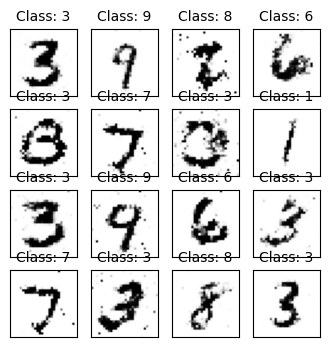

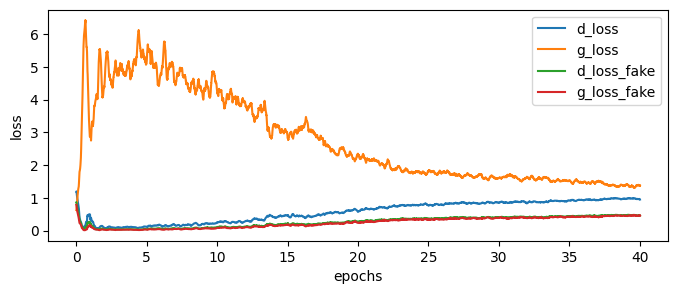

Epoch [41/200], Step[100/469], d_loss: 0.9402, d_loss_fake: 0.4349, g_loss: 1.2153, g_loss_fake: 0.4906, D(x): 0.67, D(G(z)): 0.30
Epoch [41/200], Step[200/469], d_loss: 1.0207, d_loss_fake: 0.6067, g_loss: 1.2938, g_loss_fake: 0.4954, D(x): 0.71, D(G(z)): 0.39
Epoch [41/200], Step[300/469], d_loss: 1.0467, d_loss_fake: 0.4190, g_loss: 1.2587, g_loss_fake: 0.4679, D(x): 0.62, D(G(z)): 0.29
Epoch [41/200], Step[400/469], d_loss: 1.0015, d_loss_fake: 0.5687, g_loss: 1.3680, g_loss_fake: 0.4601, D(x): 0.71, D(G(z)): 0.38
Epoch [42/200], Step[100/469], d_loss: 1.0751, d_loss_fake: 0.5182, g_loss: 1.3094, g_loss_fake: 0.4815, D(x): 0.63, D(G(z)): 0.34
Epoch [42/200], Step[200/469], d_loss: 1.0414, d_loss_fake: 0.5136, g_loss: 1.4094, g_loss_fake: 0.3974, D(x): 0.66, D(G(z)): 0.35
Epoch [42/200], Step[300/469], d_loss: 0.9868, d_loss_fake: 0.4548, g_loss: 1.4211, g_loss_fake: 0.3965, D(x): 0.67, D(G(z)): 0.33
Epoch [42/200], Step[400/469], d_loss: 1.0250, d_loss_fake: 0.4204, g_loss: 1.2825,

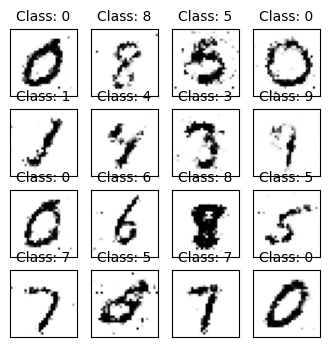

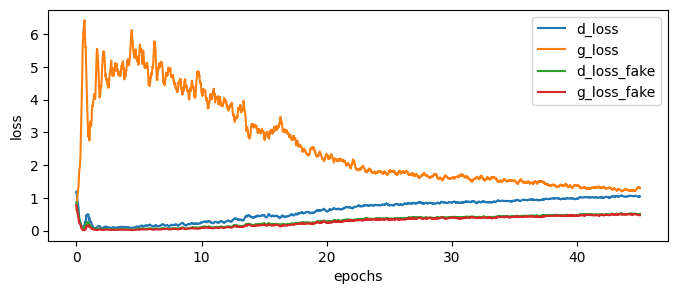

Epoch [46/200], Step[100/469], d_loss: 1.0894, d_loss_fake: 0.5583, g_loss: 1.2035, g_loss_fake: 0.5494, D(x): 0.65, D(G(z)): 0.38
Epoch [46/200], Step[200/469], d_loss: 1.0465, d_loss_fake: 0.5071, g_loss: 1.1275, g_loss_fake: 0.5321, D(x): 0.65, D(G(z)): 0.35
Epoch [46/200], Step[300/469], d_loss: 0.9147, d_loss_fake: 0.4462, g_loss: 1.3375, g_loss_fake: 0.4321, D(x): 0.68, D(G(z)): 0.33
Epoch [46/200], Step[400/469], d_loss: 1.0843, d_loss_fake: 0.4641, g_loss: 1.2775, g_loss_fake: 0.4363, D(x): 0.60, D(G(z)): 0.33
Epoch [47/200], Step[100/469], d_loss: 1.1204, d_loss_fake: 0.6343, g_loss: 1.1483, g_loss_fake: 0.5385, D(x): 0.67, D(G(z)): 0.40
Epoch [47/200], Step[200/469], d_loss: 1.0189, d_loss_fake: 0.4740, g_loss: 1.2723, g_loss_fake: 0.4956, D(x): 0.64, D(G(z)): 0.35
Epoch [47/200], Step[300/469], d_loss: 1.0187, d_loss_fake: 0.5430, g_loss: 1.2994, g_loss_fake: 0.4858, D(x): 0.68, D(G(z)): 0.36
Epoch [47/200], Step[400/469], d_loss: 1.0315, d_loss_fake: 0.4081, g_loss: 1.4238,

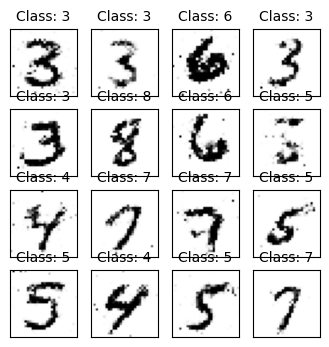

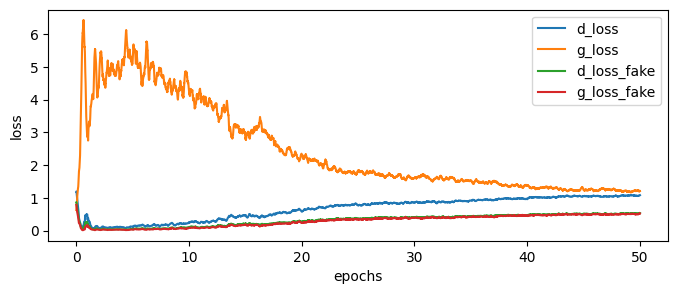

Epoch [51/200], Step[100/469], d_loss: 1.1506, d_loss_fake: 0.5250, g_loss: 1.2159, g_loss_fake: 0.4706, D(x): 0.61, D(G(z)): 0.36
Epoch [51/200], Step[200/469], d_loss: 1.1496, d_loss_fake: 0.5833, g_loss: 1.1524, g_loss_fake: 0.5149, D(x): 0.63, D(G(z)): 0.39
Epoch [51/200], Step[300/469], d_loss: 1.1480, d_loss_fake: 0.4618, g_loss: 1.2175, g_loss_fake: 0.4578, D(x): 0.58, D(G(z)): 0.34
Epoch [51/200], Step[400/469], d_loss: 1.0285, d_loss_fake: 0.4611, g_loss: 1.2794, g_loss_fake: 0.5222, D(x): 0.63, D(G(z)): 0.33
Epoch [52/200], Step[100/469], d_loss: 0.9770, d_loss_fake: 0.4660, g_loss: 1.4129, g_loss_fake: 0.4396, D(x): 0.65, D(G(z)): 0.33
Epoch [52/200], Step[200/469], d_loss: 1.1580, d_loss_fake: 0.5004, g_loss: 1.1259, g_loss_fake: 0.5234, D(x): 0.59, D(G(z)): 0.36
Epoch [52/200], Step[300/469], d_loss: 1.1290, d_loss_fake: 0.5668, g_loss: 1.0720, g_loss_fake: 0.6068, D(x): 0.64, D(G(z)): 0.39
Epoch [52/200], Step[400/469], d_loss: 1.1278, d_loss_fake: 0.5800, g_loss: 1.1857,

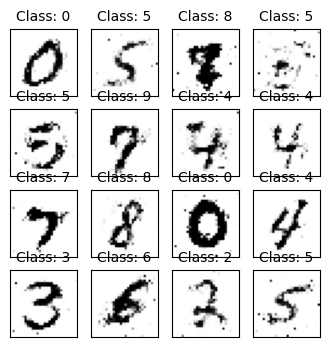

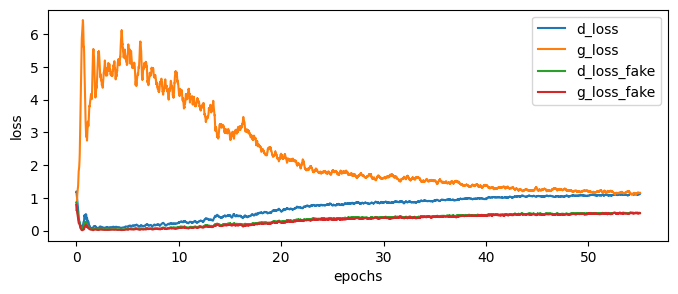

Epoch [56/200], Step[100/469], d_loss: 1.0790, d_loss_fake: 0.4924, g_loss: 1.2888, g_loss_fake: 0.4881, D(x): 0.62, D(G(z)): 0.35
Epoch [56/200], Step[200/469], d_loss: 1.1667, d_loss_fake: 0.6495, g_loss: 1.3352, g_loss_fake: 0.5074, D(x): 0.66, D(G(z)): 0.40
Epoch [56/200], Step[300/469], d_loss: 1.1223, d_loss_fake: 0.5680, g_loss: 1.1103, g_loss_fake: 0.5317, D(x): 0.63, D(G(z)): 0.39
Epoch [56/200], Step[400/469], d_loss: 1.0238, d_loss_fake: 0.5254, g_loss: 1.2468, g_loss_fake: 0.4556, D(x): 0.65, D(G(z)): 0.37
Epoch [57/200], Step[100/469], d_loss: 0.9773, d_loss_fake: 0.4070, g_loss: 1.2504, g_loss_fake: 0.4458, D(x): 0.62, D(G(z)): 0.31
Epoch [57/200], Step[200/469], d_loss: 1.0883, d_loss_fake: 0.5384, g_loss: 1.0625, g_loss_fake: 0.6017, D(x): 0.62, D(G(z)): 0.38
Epoch [57/200], Step[300/469], d_loss: 1.1439, d_loss_fake: 0.4985, g_loss: 1.0929, g_loss_fake: 0.5251, D(x): 0.58, D(G(z)): 0.36
Epoch [57/200], Step[400/469], d_loss: 1.2022, d_loss_fake: 0.5898, g_loss: 1.0448,

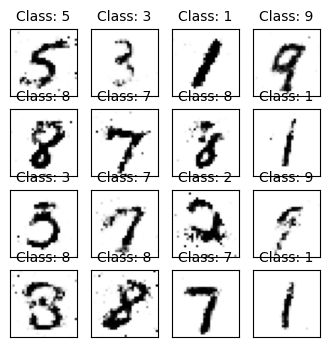

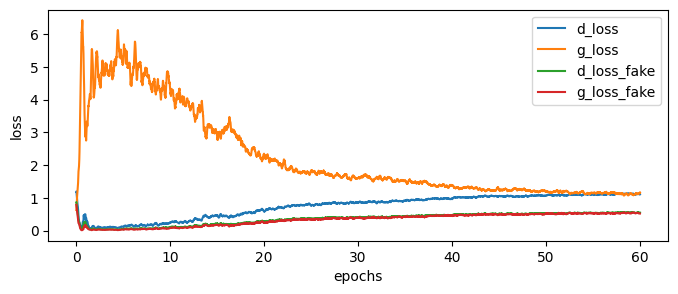

Epoch [61/200], Step[100/469], d_loss: 1.1753, d_loss_fake: 0.6056, g_loss: 1.0419, g_loss_fake: 0.5616, D(x): 0.62, D(G(z)): 0.41
Epoch [61/200], Step[200/469], d_loss: 1.0116, d_loss_fake: 0.3904, g_loss: 1.4033, g_loss_fake: 0.3810, D(x): 0.60, D(G(z)): 0.30
Epoch [61/200], Step[300/469], d_loss: 1.1537, d_loss_fake: 0.6298, g_loss: 1.0988, g_loss_fake: 0.5432, D(x): 0.64, D(G(z)): 0.42
Epoch [61/200], Step[400/469], d_loss: 1.0152, d_loss_fake: 0.5879, g_loss: 0.9636, g_loss_fake: 0.6346, D(x): 0.70, D(G(z)): 0.41
Epoch [62/200], Step[100/469], d_loss: 1.0927, d_loss_fake: 0.4947, g_loss: 1.0783, g_loss_fake: 0.5580, D(x): 0.60, D(G(z)): 0.36
Epoch [62/200], Step[200/469], d_loss: 1.1027, d_loss_fake: 0.5671, g_loss: 1.0580, g_loss_fake: 0.5563, D(x): 0.64, D(G(z)): 0.40
Epoch [62/200], Step[300/469], d_loss: 1.1606, d_loss_fake: 0.6371, g_loss: 1.0011, g_loss_fake: 0.6025, D(x): 0.64, D(G(z)): 0.40
Epoch [62/200], Step[400/469], d_loss: 1.1457, d_loss_fake: 0.5367, g_loss: 1.0560,

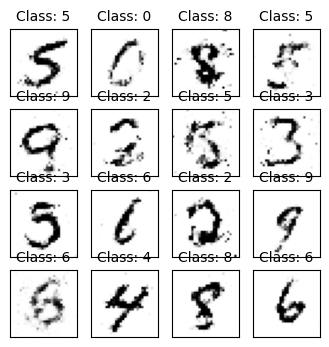

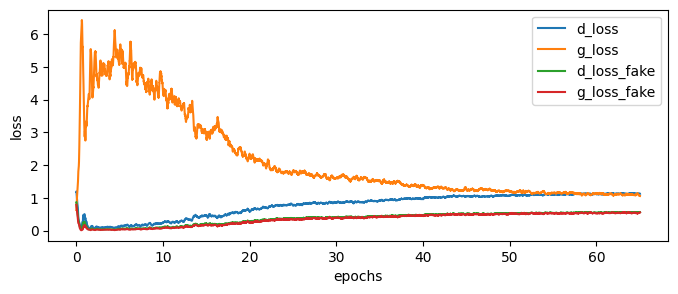

Epoch [66/200], Step[100/469], d_loss: 1.1342, d_loss_fake: 0.6024, g_loss: 0.9711, g_loss_fake: 0.6437, D(x): 0.64, D(G(z)): 0.40
Epoch [66/200], Step[200/469], d_loss: 1.1328, d_loss_fake: 0.5726, g_loss: 1.0645, g_loss_fake: 0.5646, D(x): 0.62, D(G(z)): 0.40
Epoch [66/200], Step[300/469], d_loss: 1.1001, d_loss_fake: 0.5095, g_loss: 1.1442, g_loss_fake: 0.5594, D(x): 0.61, D(G(z)): 0.37
Epoch [66/200], Step[400/469], d_loss: 1.1493, d_loss_fake: 0.5636, g_loss: 1.0708, g_loss_fake: 0.5654, D(x): 0.61, D(G(z)): 0.39
Epoch [67/200], Step[100/469], d_loss: 1.1345, d_loss_fake: 0.6058, g_loss: 1.1584, g_loss_fake: 0.4831, D(x): 0.64, D(G(z)): 0.42
Epoch [67/200], Step[200/469], d_loss: 1.1010, d_loss_fake: 0.5562, g_loss: 1.1713, g_loss_fake: 0.4845, D(x): 0.64, D(G(z)): 0.38
Epoch [67/200], Step[300/469], d_loss: 1.1890, d_loss_fake: 0.6873, g_loss: 0.9234, g_loss_fake: 0.7311, D(x): 0.64, D(G(z)): 0.45
Epoch [67/200], Step[400/469], d_loss: 1.1520, d_loss_fake: 0.5249, g_loss: 1.0702,

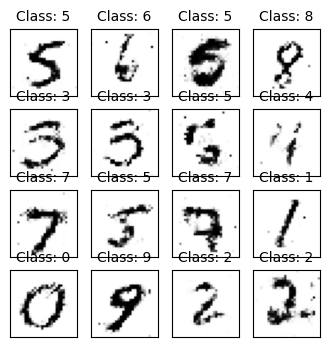

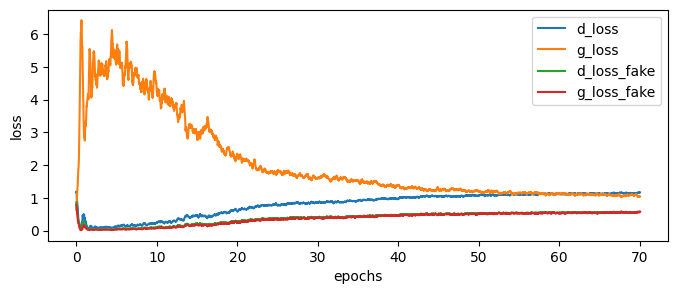

Epoch [71/200], Step[100/469], d_loss: 1.1873, d_loss_fake: 0.6070, g_loss: 0.9620, g_loss_fake: 0.6492, D(x): 0.61, D(G(z)): 0.42
Epoch [71/200], Step[200/469], d_loss: 1.1483, d_loss_fake: 0.5478, g_loss: 1.0162, g_loss_fake: 0.6089, D(x): 0.61, D(G(z)): 0.39
Epoch [71/200], Step[300/469], d_loss: 1.1896, d_loss_fake: 0.4969, g_loss: 0.9953, g_loss_fake: 0.5872, D(x): 0.56, D(G(z)): 0.35
Epoch [71/200], Step[400/469], d_loss: 1.1727, d_loss_fake: 0.6317, g_loss: 0.9067, g_loss_fake: 0.6687, D(x): 0.63, D(G(z)): 0.42
Epoch [72/200], Step[100/469], d_loss: 1.1431, d_loss_fake: 0.6525, g_loss: 0.9648, g_loss_fake: 0.6300, D(x): 0.67, D(G(z)): 0.43
Epoch [72/200], Step[200/469], d_loss: 1.1224, d_loss_fake: 0.5366, g_loss: 1.1134, g_loss_fake: 0.5054, D(x): 0.60, D(G(z)): 0.39
Epoch [72/200], Step[300/469], d_loss: 1.2080, d_loss_fake: 0.6474, g_loss: 0.9401, g_loss_fake: 0.6259, D(x): 0.61, D(G(z)): 0.45
Epoch [72/200], Step[400/469], d_loss: 1.1600, d_loss_fake: 0.6282, g_loss: 1.0654,

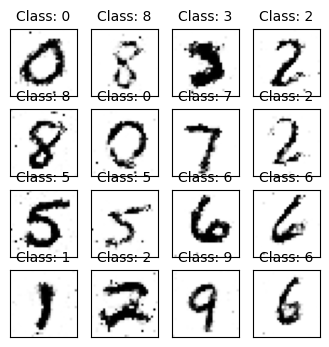

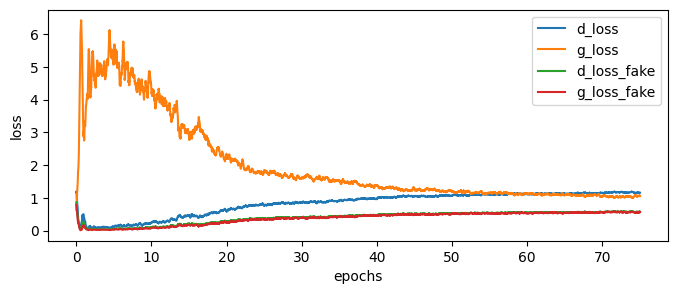

Epoch [76/200], Step[100/469], d_loss: 1.1996, d_loss_fake: 0.6017, g_loss: 1.1505, g_loss_fake: 0.6163, D(x): 0.61, D(G(z)): 0.41
Epoch [76/200], Step[200/469], d_loss: 1.1906, d_loss_fake: 0.7169, g_loss: 0.8758, g_loss_fake: 0.6940, D(x): 0.66, D(G(z)): 0.47
Epoch [76/200], Step[300/469], d_loss: 1.1739, d_loss_fake: 0.5457, g_loss: 1.0702, g_loss_fake: 0.5321, D(x): 0.59, D(G(z)): 0.39
Epoch [76/200], Step[400/469], d_loss: 1.1078, d_loss_fake: 0.6374, g_loss: 0.9996, g_loss_fake: 0.6066, D(x): 0.65, D(G(z)): 0.44
Epoch [77/200], Step[100/469], d_loss: 1.2576, d_loss_fake: 0.6796, g_loss: 0.9641, g_loss_fake: 0.6891, D(x): 0.61, D(G(z)): 0.44
Epoch [77/200], Step[200/469], d_loss: 1.1349, d_loss_fake: 0.5565, g_loss: 1.1551, g_loss_fake: 0.4970, D(x): 0.61, D(G(z)): 0.40
Epoch [77/200], Step[300/469], d_loss: 1.1927, d_loss_fake: 0.6340, g_loss: 1.1237, g_loss_fake: 0.5533, D(x): 0.62, D(G(z)): 0.44
Epoch [77/200], Step[400/469], d_loss: 1.1475, d_loss_fake: 0.6120, g_loss: 0.9365,

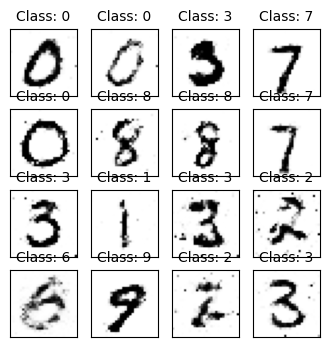

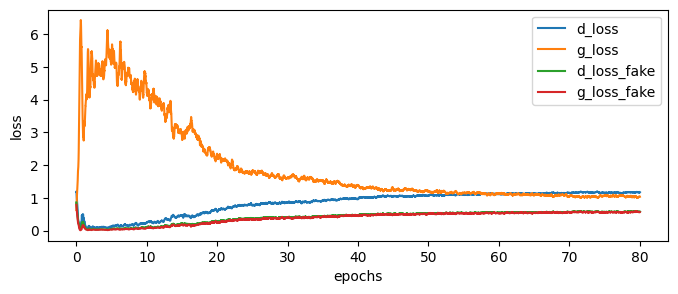

Epoch [81/200], Step[100/469], d_loss: 1.2270, d_loss_fake: 0.7131, g_loss: 0.9224, g_loss_fake: 0.6376, D(x): 0.63, D(G(z)): 0.45
Epoch [81/200], Step[200/469], d_loss: 1.2794, d_loss_fake: 0.6099, g_loss: 1.0104, g_loss_fake: 0.5801, D(x): 0.58, D(G(z)): 0.42
Epoch [81/200], Step[300/469], d_loss: 1.1630, d_loss_fake: 0.5130, g_loss: 1.1976, g_loss_fake: 0.5071, D(x): 0.58, D(G(z)): 0.37
Epoch [81/200], Step[400/469], d_loss: 1.1822, d_loss_fake: 0.6544, g_loss: 0.9246, g_loss_fake: 0.6502, D(x): 0.64, D(G(z)): 0.44
Epoch [82/200], Step[100/469], d_loss: 1.2556, d_loss_fake: 0.7132, g_loss: 0.8820, g_loss_fake: 0.6857, D(x): 0.62, D(G(z)): 0.46
Epoch [82/200], Step[200/469], d_loss: 1.2300, d_loss_fake: 0.6189, g_loss: 1.1454, g_loss_fake: 0.4974, D(x): 0.59, D(G(z)): 0.41
Epoch [82/200], Step[300/469], d_loss: 1.2138, d_loss_fake: 0.5598, g_loss: 1.0927, g_loss_fake: 0.5570, D(x): 0.57, D(G(z)): 0.39
Epoch [82/200], Step[400/469], d_loss: 1.0757, d_loss_fake: 0.5338, g_loss: 1.1205,

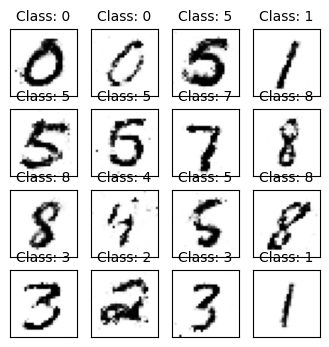

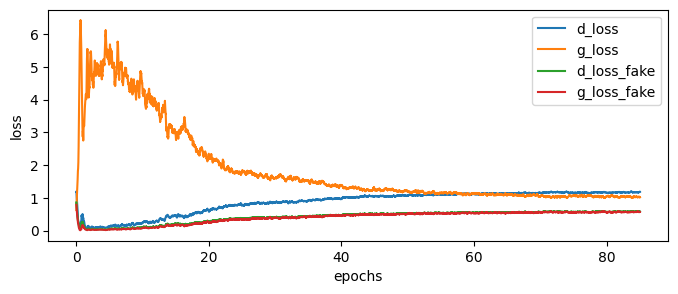

Epoch [86/200], Step[100/469], d_loss: 1.1986, d_loss_fake: 0.6460, g_loss: 0.9013, g_loss_fake: 0.6645, D(x): 0.62, D(G(z)): 0.45
Epoch [86/200], Step[200/469], d_loss: 1.2402, d_loss_fake: 0.7267, g_loss: 0.9622, g_loss_fake: 0.5799, D(x): 0.64, D(G(z)): 0.47
Epoch [86/200], Step[300/469], d_loss: 1.0566, d_loss_fake: 0.4619, g_loss: 1.0472, g_loss_fake: 0.5655, D(x): 0.60, D(G(z)): 0.35
Epoch [86/200], Step[400/469], d_loss: 0.9921, d_loss_fake: 0.4662, g_loss: 1.1481, g_loss_fake: 0.4915, D(x): 0.62, D(G(z)): 0.35
Epoch [87/200], Step[100/469], d_loss: 1.1916, d_loss_fake: 0.6010, g_loss: 0.9794, g_loss_fake: 0.5610, D(x): 0.60, D(G(z)): 0.42
Epoch [87/200], Step[200/469], d_loss: 1.2221, d_loss_fake: 0.6173, g_loss: 1.1406, g_loss_fake: 0.5226, D(x): 0.59, D(G(z)): 0.41
Epoch [87/200], Step[300/469], d_loss: 1.1537, d_loss_fake: 0.5621, g_loss: 1.0722, g_loss_fake: 0.5067, D(x): 0.59, D(G(z)): 0.40
Epoch [87/200], Step[400/469], d_loss: 1.2272, d_loss_fake: 0.6578, g_loss: 1.0157,

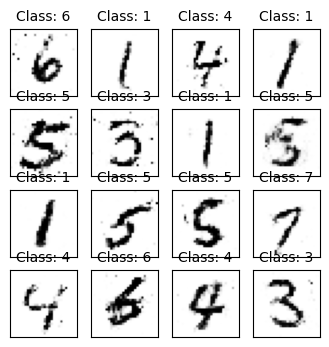

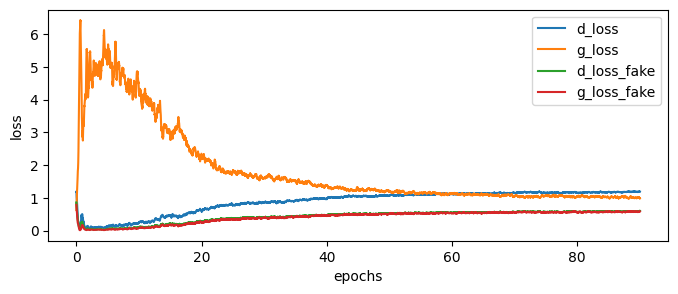

Epoch [91/200], Step[100/469], d_loss: 1.1304, d_loss_fake: 0.4926, g_loss: 1.1379, g_loss_fake: 0.5110, D(x): 0.58, D(G(z)): 0.36
Epoch [91/200], Step[200/469], d_loss: 1.1913, d_loss_fake: 0.5755, g_loss: 0.9333, g_loss_fake: 0.6377, D(x): 0.58, D(G(z)): 0.41
Epoch [91/200], Step[300/469], d_loss: 1.2022, d_loss_fake: 0.5525, g_loss: 1.0013, g_loss_fake: 0.5574, D(x): 0.56, D(G(z)): 0.40
Epoch [91/200], Step[400/469], d_loss: 1.2397, d_loss_fake: 0.7248, g_loss: 0.8531, g_loss_fake: 0.6582, D(x): 0.63, D(G(z)): 0.47
Epoch [92/200], Step[100/469], d_loss: 1.2340, d_loss_fake: 0.6222, g_loss: 0.9199, g_loss_fake: 0.6563, D(x): 0.59, D(G(z)): 0.43
Epoch [92/200], Step[200/469], d_loss: 1.1716, d_loss_fake: 0.6130, g_loss: 0.9346, g_loss_fake: 0.6039, D(x): 0.60, D(G(z)): 0.42
Epoch [92/200], Step[300/469], d_loss: 1.3141, d_loss_fake: 0.7190, g_loss: 0.9957, g_loss_fake: 0.5943, D(x): 0.59, D(G(z)): 0.48
Epoch [92/200], Step[400/469], d_loss: 1.1648, d_loss_fake: 0.6174, g_loss: 0.9593,

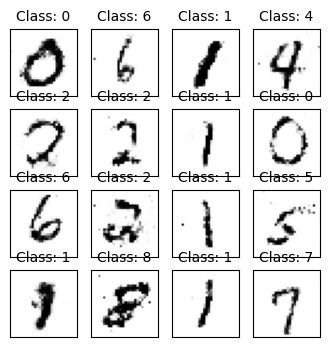

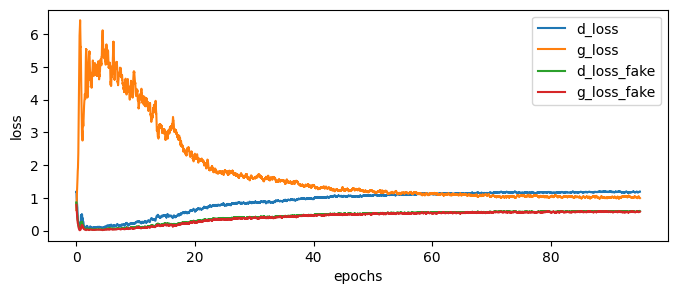

Epoch [96/200], Step[100/469], d_loss: 1.1503, d_loss_fake: 0.5583, g_loss: 0.9105, g_loss_fake: 0.6410, D(x): 0.59, D(G(z)): 0.41
Epoch [96/200], Step[200/469], d_loss: 1.1748, d_loss_fake: 0.5649, g_loss: 0.9792, g_loss_fake: 0.5746, D(x): 0.59, D(G(z)): 0.40
Epoch [96/200], Step[300/469], d_loss: 1.1532, d_loss_fake: 0.6045, g_loss: 0.9091, g_loss_fake: 0.6472, D(x): 0.62, D(G(z)): 0.42
Epoch [96/200], Step[400/469], d_loss: 1.1683, d_loss_fake: 0.5108, g_loss: 1.1195, g_loss_fake: 0.4988, D(x): 0.56, D(G(z)): 0.37
Epoch [97/200], Step[100/469], d_loss: 1.1492, d_loss_fake: 0.5796, g_loss: 1.1269, g_loss_fake: 0.5190, D(x): 0.60, D(G(z)): 0.41
Epoch [97/200], Step[200/469], d_loss: 1.1849, d_loss_fake: 0.5723, g_loss: 0.9927, g_loss_fake: 0.5818, D(x): 0.58, D(G(z)): 0.40
Epoch [97/200], Step[300/469], d_loss: 1.2464, d_loss_fake: 0.5946, g_loss: 1.0008, g_loss_fake: 0.5906, D(x): 0.57, D(G(z)): 0.41
Epoch [97/200], Step[400/469], d_loss: 1.1422, d_loss_fake: 0.5777, g_loss: 0.9903,

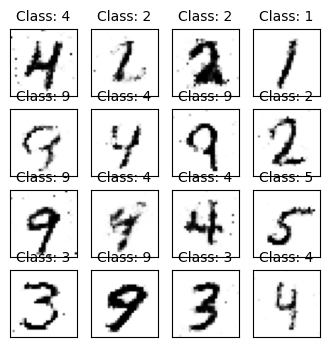

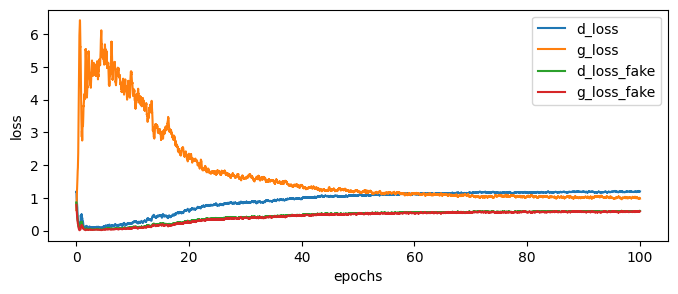

Epoch [101/200], Step[100/469], d_loss: 1.2098, d_loss_fake: 0.6566, g_loss: 0.9471, g_loss_fake: 0.6246, D(x): 0.61, D(G(z)): 0.45
Epoch [101/200], Step[200/469], d_loss: 1.2168, d_loss_fake: 0.6803, g_loss: 0.8983, g_loss_fake: 0.6874, D(x): 0.62, D(G(z)): 0.46
Epoch [101/200], Step[300/469], d_loss: 1.2280, d_loss_fake: 0.6155, g_loss: 0.9804, g_loss_fake: 0.5727, D(x): 0.58, D(G(z)): 0.43
Epoch [101/200], Step[400/469], d_loss: 1.2170, d_loss_fake: 0.6393, g_loss: 0.9786, g_loss_fake: 0.5808, D(x): 0.60, D(G(z)): 0.44
Epoch [102/200], Step[100/469], d_loss: 1.2514, d_loss_fake: 0.7022, g_loss: 0.9052, g_loss_fake: 0.6766, D(x): 0.61, D(G(z)): 0.46
Epoch [102/200], Step[200/469], d_loss: 1.1480, d_loss_fake: 0.5877, g_loss: 0.9677, g_loss_fake: 0.5925, D(x): 0.61, D(G(z)): 0.42
Epoch [102/200], Step[300/469], d_loss: 1.2623, d_loss_fake: 0.6245, g_loss: 0.9001, g_loss_fake: 0.6664, D(x): 0.57, D(G(z)): 0.43
Epoch [102/200], Step[400/469], d_loss: 1.1628, d_loss_fake: 0.6107, g_loss:

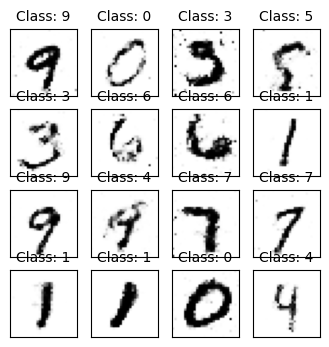

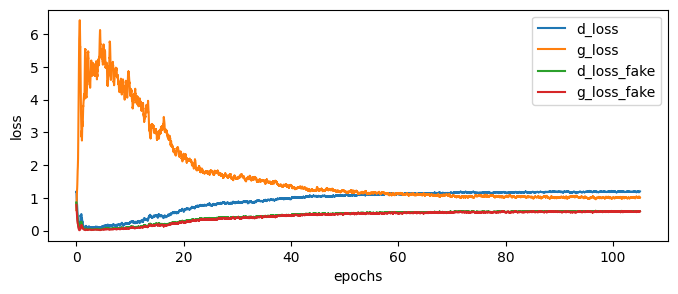

Epoch [106/200], Step[100/469], d_loss: 1.1612, d_loss_fake: 0.5497, g_loss: 0.9882, g_loss_fake: 0.5722, D(x): 0.58, D(G(z)): 0.39
Epoch [106/200], Step[200/469], d_loss: 1.2200, d_loss_fake: 0.6066, g_loss: 0.9410, g_loss_fake: 0.6000, D(x): 0.59, D(G(z)): 0.42
Epoch [106/200], Step[300/469], d_loss: 1.2019, d_loss_fake: 0.6299, g_loss: 1.0153, g_loss_fake: 0.5950, D(x): 0.61, D(G(z)): 0.42
Epoch [106/200], Step[400/469], d_loss: 1.2403, d_loss_fake: 0.6042, g_loss: 0.9226, g_loss_fake: 0.5882, D(x): 0.56, D(G(z)): 0.43
Epoch [107/200], Step[100/469], d_loss: 1.2111, d_loss_fake: 0.5808, g_loss: 1.0168, g_loss_fake: 0.5141, D(x): 0.57, D(G(z)): 0.40
Epoch [107/200], Step[200/469], d_loss: 1.1857, d_loss_fake: 0.5116, g_loss: 1.1217, g_loss_fake: 0.5202, D(x): 0.57, D(G(z)): 0.36
Epoch [107/200], Step[300/469], d_loss: 1.2638, d_loss_fake: 0.6399, g_loss: 0.9326, g_loss_fake: 0.6160, D(x): 0.58, D(G(z)): 0.44
Epoch [107/200], Step[400/469], d_loss: 1.2549, d_loss_fake: 0.5535, g_loss:

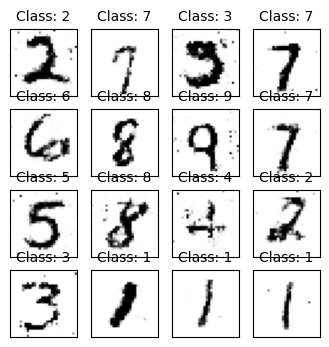

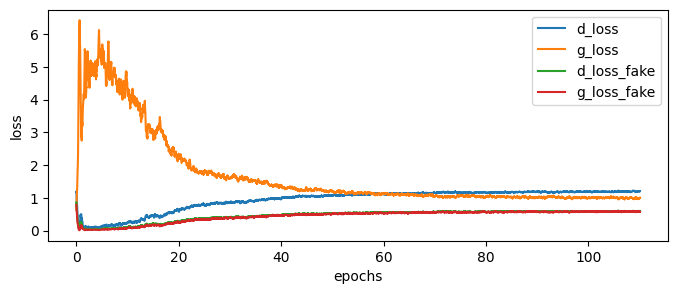

Epoch [111/200], Step[100/469], d_loss: 1.2001, d_loss_fake: 0.5936, g_loss: 0.9830, g_loss_fake: 0.5789, D(x): 0.58, D(G(z)): 0.42
Epoch [111/200], Step[200/469], d_loss: 1.2900, d_loss_fake: 0.6258, g_loss: 0.9090, g_loss_fake: 0.6034, D(x): 0.56, D(G(z)): 0.43
Epoch [111/200], Step[300/469], d_loss: 1.1602, d_loss_fake: 0.5912, g_loss: 1.1235, g_loss_fake: 0.5117, D(x): 0.61, D(G(z)): 0.41
Epoch [111/200], Step[400/469], d_loss: 1.2488, d_loss_fake: 0.6167, g_loss: 0.9241, g_loss_fake: 0.6304, D(x): 0.57, D(G(z)): 0.40
Epoch [112/200], Step[100/469], d_loss: 1.1793, d_loss_fake: 0.6187, g_loss: 0.9679, g_loss_fake: 0.5819, D(x): 0.61, D(G(z)): 0.43
Epoch [112/200], Step[200/469], d_loss: 1.2714, d_loss_fake: 0.5887, g_loss: 0.9679, g_loss_fake: 0.5723, D(x): 0.55, D(G(z)): 0.42
Epoch [112/200], Step[300/469], d_loss: 1.2634, d_loss_fake: 0.5973, g_loss: 1.0410, g_loss_fake: 0.5392, D(x): 0.56, D(G(z)): 0.42
Epoch [112/200], Step[400/469], d_loss: 1.2536, d_loss_fake: 0.6130, g_loss:

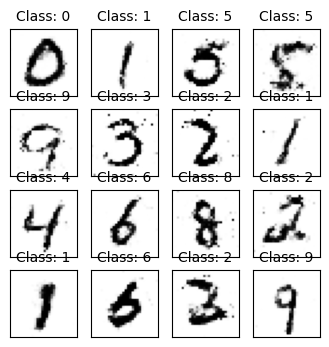

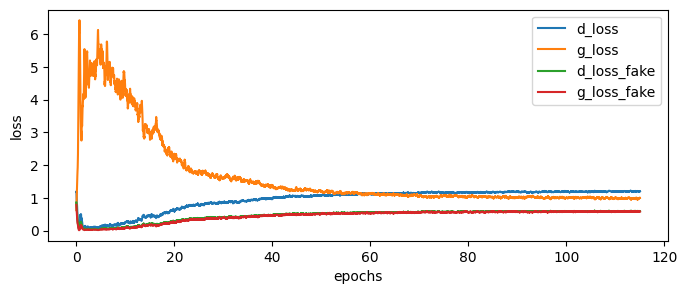

Epoch [116/200], Step[100/469], d_loss: 1.1947, d_loss_fake: 0.6091, g_loss: 0.9301, g_loss_fake: 0.6140, D(x): 0.58, D(G(z)): 0.43
Epoch [116/200], Step[200/469], d_loss: 1.2059, d_loss_fake: 0.6051, g_loss: 0.9666, g_loss_fake: 0.5854, D(x): 0.59, D(G(z)): 0.42
Epoch [116/200], Step[300/469], d_loss: 1.2349, d_loss_fake: 0.5546, g_loss: 1.0396, g_loss_fake: 0.5704, D(x): 0.55, D(G(z)): 0.40
Epoch [116/200], Step[400/469], d_loss: 1.1543, d_loss_fake: 0.6381, g_loss: 0.8832, g_loss_fake: 0.6281, D(x): 0.63, D(G(z)): 0.44
Epoch [117/200], Step[100/469], d_loss: 1.2678, d_loss_fake: 0.5616, g_loss: 0.9650, g_loss_fake: 0.6479, D(x): 0.54, D(G(z)): 0.39
Epoch [117/200], Step[200/469], d_loss: 1.2376, d_loss_fake: 0.5830, g_loss: 0.9684, g_loss_fake: 0.5811, D(x): 0.56, D(G(z)): 0.41
Epoch [117/200], Step[300/469], d_loss: 1.1883, d_loss_fake: 0.5046, g_loss: 1.0758, g_loss_fake: 0.5343, D(x): 0.54, D(G(z)): 0.37
Epoch [117/200], Step[400/469], d_loss: 1.1955, d_loss_fake: 0.6088, g_loss:

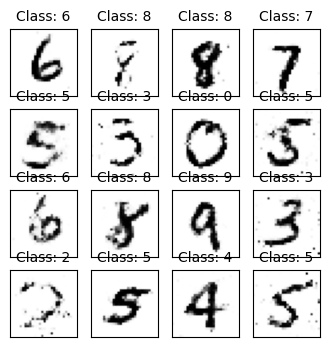

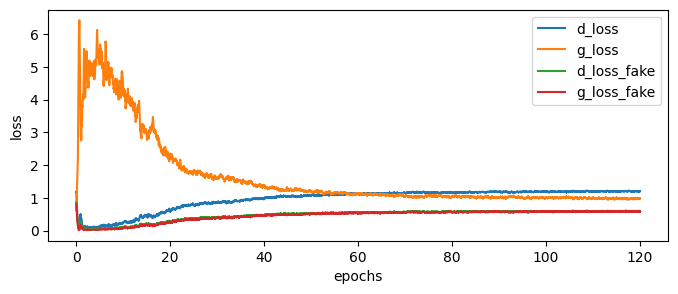

Epoch [121/200], Step[100/469], d_loss: 1.1904, d_loss_fake: 0.5736, g_loss: 0.9252, g_loss_fake: 0.6034, D(x): 0.58, D(G(z)): 0.41
Epoch [121/200], Step[200/469], d_loss: 1.1828, d_loss_fake: 0.6621, g_loss: 0.8471, g_loss_fake: 0.6605, D(x): 0.62, D(G(z)): 0.45
Epoch [121/200], Step[300/469], d_loss: 1.2201, d_loss_fake: 0.5201, g_loss: 0.9674, g_loss_fake: 0.5693, D(x): 0.54, D(G(z)): 0.38
Epoch [121/200], Step[400/469], d_loss: 1.3210, d_loss_fake: 0.6024, g_loss: 0.9531, g_loss_fake: 0.5744, D(x): 0.53, D(G(z)): 0.43
Epoch [122/200], Step[100/469], d_loss: 1.2396, d_loss_fake: 0.6327, g_loss: 0.8266, g_loss_fake: 0.6598, D(x): 0.58, D(G(z)): 0.44
Epoch [122/200], Step[200/469], d_loss: 1.2272, d_loss_fake: 0.6179, g_loss: 1.0436, g_loss_fake: 0.5800, D(x): 0.58, D(G(z)): 0.41
Epoch [122/200], Step[300/469], d_loss: 1.2147, d_loss_fake: 0.6133, g_loss: 0.8735, g_loss_fake: 0.6342, D(x): 0.59, D(G(z)): 0.43
Epoch [122/200], Step[400/469], d_loss: 1.1907, d_loss_fake: 0.6002, g_loss:

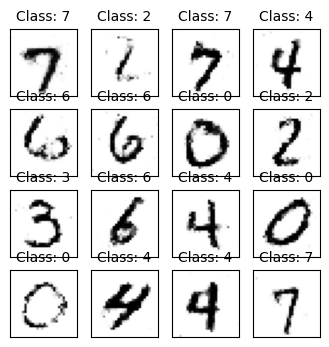

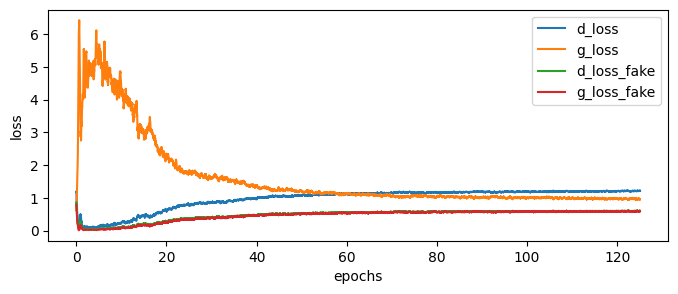

Epoch [126/200], Step[100/469], d_loss: 1.1981, d_loss_fake: 0.6666, g_loss: 0.8785, g_loss_fake: 0.6624, D(x): 0.63, D(G(z)): 0.45
Epoch [126/200], Step[200/469], d_loss: 1.2179, d_loss_fake: 0.6285, g_loss: 0.9138, g_loss_fake: 0.6700, D(x): 0.59, D(G(z)): 0.44
Epoch [126/200], Step[300/469], d_loss: 1.2437, d_loss_fake: 0.5048, g_loss: 1.0659, g_loss_fake: 0.5207, D(x): 0.53, D(G(z)): 0.37
Epoch [126/200], Step[400/469], d_loss: 1.1940, d_loss_fake: 0.5989, g_loss: 1.1307, g_loss_fake: 0.5069, D(x): 0.59, D(G(z)): 0.42
Epoch [127/200], Step[100/469], d_loss: 1.1873, d_loss_fake: 0.5855, g_loss: 0.9293, g_loss_fake: 0.5887, D(x): 0.58, D(G(z)): 0.43
Epoch [127/200], Step[200/469], d_loss: 1.2823, d_loss_fake: 0.5912, g_loss: 1.0810, g_loss_fake: 0.5152, D(x): 0.55, D(G(z)): 0.42
Epoch [127/200], Step[300/469], d_loss: 1.1820, d_loss_fake: 0.7079, g_loss: 0.8697, g_loss_fake: 0.6802, D(x): 0.65, D(G(z)): 0.47
Epoch [127/200], Step[400/469], d_loss: 1.2634, d_loss_fake: 0.6646, g_loss:

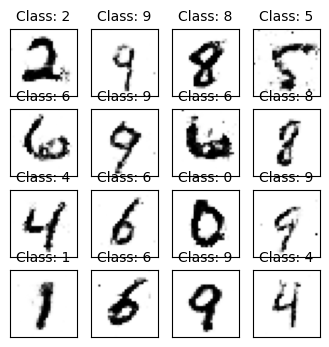

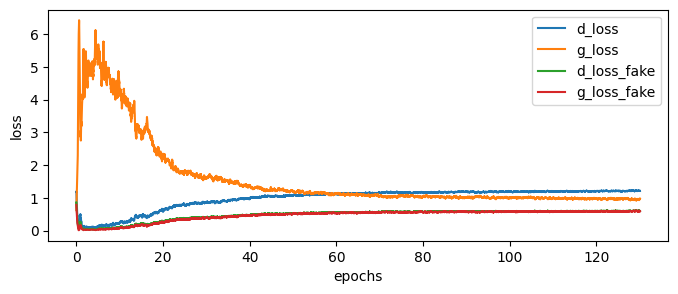

Epoch [131/200], Step[100/469], d_loss: 1.2402, d_loss_fake: 0.6418, g_loss: 0.9328, g_loss_fake: 0.5831, D(x): 0.59, D(G(z)): 0.44
Epoch [131/200], Step[200/469], d_loss: 1.2753, d_loss_fake: 0.6665, g_loss: 0.9576, g_loss_fake: 0.6017, D(x): 0.59, D(G(z)): 0.45
Epoch [131/200], Step[300/469], d_loss: 1.2465, d_loss_fake: 0.6936, g_loss: 0.8149, g_loss_fake: 0.6890, D(x): 0.60, D(G(z)): 0.47
Epoch [131/200], Step[400/469], d_loss: 1.2707, d_loss_fake: 0.5999, g_loss: 1.0076, g_loss_fake: 0.5650, D(x): 0.56, D(G(z)): 0.43
Epoch [132/200], Step[100/469], d_loss: 1.1850, d_loss_fake: 0.5483, g_loss: 1.0939, g_loss_fake: 0.5188, D(x): 0.58, D(G(z)): 0.40
Epoch [132/200], Step[200/469], d_loss: 1.1979, d_loss_fake: 0.5641, g_loss: 0.9462, g_loss_fake: 0.5979, D(x): 0.57, D(G(z)): 0.41
Epoch [132/200], Step[300/469], d_loss: 1.2538, d_loss_fake: 0.6280, g_loss: 0.9364, g_loss_fake: 0.6217, D(x): 0.58, D(G(z)): 0.43
Epoch [132/200], Step[400/469], d_loss: 1.1893, d_loss_fake: 0.5270, g_loss:

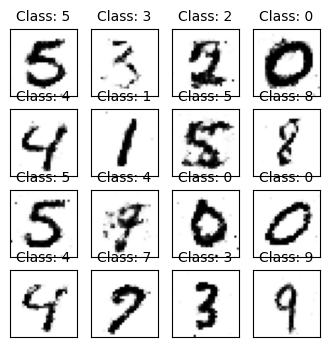

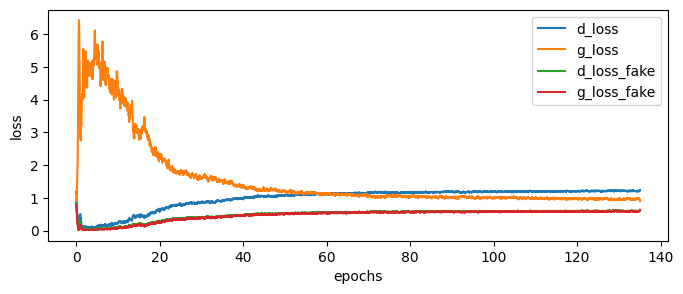

Epoch [136/200], Step[100/469], d_loss: 1.2267, d_loss_fake: 0.6332, g_loss: 0.8886, g_loss_fake: 0.6408, D(x): 0.59, D(G(z)): 0.44
Epoch [136/200], Step[200/469], d_loss: 1.2951, d_loss_fake: 0.5964, g_loss: 0.8986, g_loss_fake: 0.6649, D(x): 0.54, D(G(z)): 0.42
Epoch [136/200], Step[300/469], d_loss: 1.0755, d_loss_fake: 0.4883, g_loss: 1.0212, g_loss_fake: 0.5148, D(x): 0.59, D(G(z)): 0.36
Epoch [136/200], Step[400/469], d_loss: 1.2530, d_loss_fake: 0.6778, g_loss: 1.0139, g_loss_fake: 0.5759, D(x): 0.60, D(G(z)): 0.45
Epoch [137/200], Step[100/469], d_loss: 1.1763, d_loss_fake: 0.5618, g_loss: 1.0448, g_loss_fake: 0.5423, D(x): 0.57, D(G(z)): 0.40
Epoch [137/200], Step[200/469], d_loss: 1.2177, d_loss_fake: 0.5839, g_loss: 1.0658, g_loss_fake: 0.5238, D(x): 0.57, D(G(z)): 0.41
Epoch [137/200], Step[300/469], d_loss: 1.1478, d_loss_fake: 0.5846, g_loss: 1.0250, g_loss_fake: 0.5392, D(x): 0.60, D(G(z)): 0.42
Epoch [137/200], Step[400/469], d_loss: 1.2451, d_loss_fake: 0.5817, g_loss:

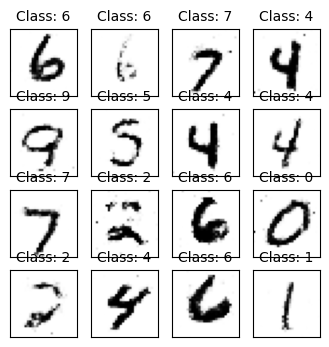

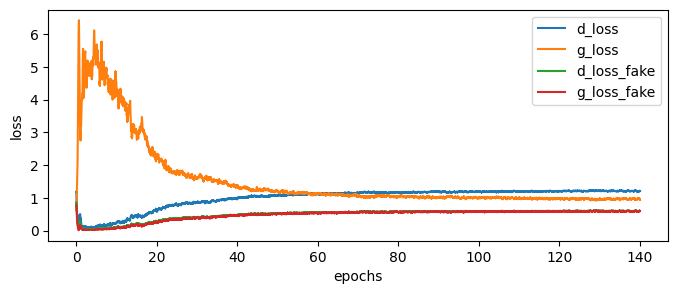

Epoch [141/200], Step[100/469], d_loss: 1.2829, d_loss_fake: 0.6434, g_loss: 0.9334, g_loss_fake: 0.5881, D(x): 0.56, D(G(z)): 0.44
Epoch [141/200], Step[200/469], d_loss: 1.2534, d_loss_fake: 0.6931, g_loss: 0.8834, g_loss_fake: 0.6466, D(x): 0.61, D(G(z)): 0.47
Epoch [141/200], Step[300/469], d_loss: 1.1983, d_loss_fake: 0.7336, g_loss: 0.8466, g_loss_fake: 0.6589, D(x): 0.66, D(G(z)): 0.48
Epoch [141/200], Step[400/469], d_loss: 1.2666, d_loss_fake: 0.6363, g_loss: 0.9860, g_loss_fake: 0.5767, D(x): 0.57, D(G(z)): 0.44
Epoch [142/200], Step[100/469], d_loss: 1.3109, d_loss_fake: 0.6617, g_loss: 0.9311, g_loss_fake: 0.6085, D(x): 0.57, D(G(z)): 0.43
Epoch [142/200], Step[200/469], d_loss: 1.3077, d_loss_fake: 0.6051, g_loss: 0.9929, g_loss_fake: 0.5729, D(x): 0.54, D(G(z)): 0.41
Epoch [142/200], Step[300/469], d_loss: 1.1857, d_loss_fake: 0.5497, g_loss: 1.0785, g_loss_fake: 0.5489, D(x): 0.57, D(G(z)): 0.39
Epoch [142/200], Step[400/469], d_loss: 1.2748, d_loss_fake: 0.5579, g_loss:

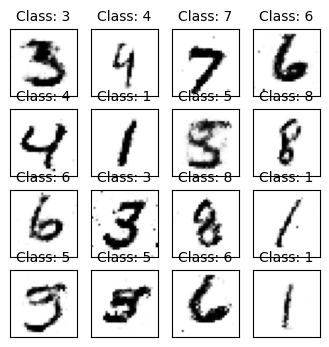

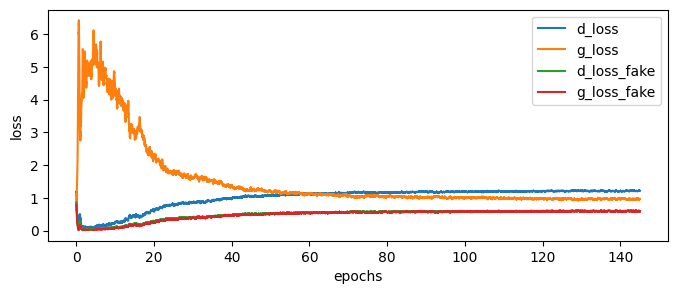

Epoch [146/200], Step[100/469], d_loss: 1.2148, d_loss_fake: 0.5946, g_loss: 0.9950, g_loss_fake: 0.5443, D(x): 0.58, D(G(z)): 0.42
Epoch [146/200], Step[200/469], d_loss: 1.2799, d_loss_fake: 0.6076, g_loss: 0.9861, g_loss_fake: 0.5600, D(x): 0.55, D(G(z)): 0.42
Epoch [146/200], Step[300/469], d_loss: 1.2560, d_loss_fake: 0.5647, g_loss: 1.0310, g_loss_fake: 0.5484, D(x): 0.54, D(G(z)): 0.40
Epoch [146/200], Step[400/469], d_loss: 1.3068, d_loss_fake: 0.7212, g_loss: 0.8367, g_loss_fake: 0.6823, D(x): 0.59, D(G(z)): 0.47
Epoch [147/200], Step[100/469], d_loss: 1.1994, d_loss_fake: 0.5927, g_loss: 0.9402, g_loss_fake: 0.5886, D(x): 0.58, D(G(z)): 0.42
Epoch [147/200], Step[200/469], d_loss: 1.1599, d_loss_fake: 0.5896, g_loss: 0.9112, g_loss_fake: 0.6158, D(x): 0.60, D(G(z)): 0.41
Epoch [147/200], Step[300/469], d_loss: 1.2415, d_loss_fake: 0.5124, g_loss: 1.1093, g_loss_fake: 0.4940, D(x): 0.52, D(G(z)): 0.39
Epoch [147/200], Step[400/469], d_loss: 1.2314, d_loss_fake: 0.6546, g_loss:

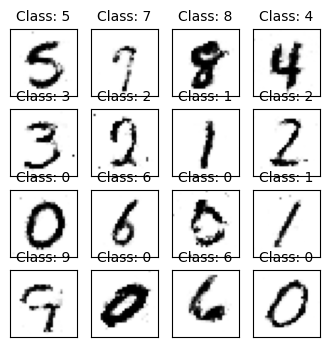

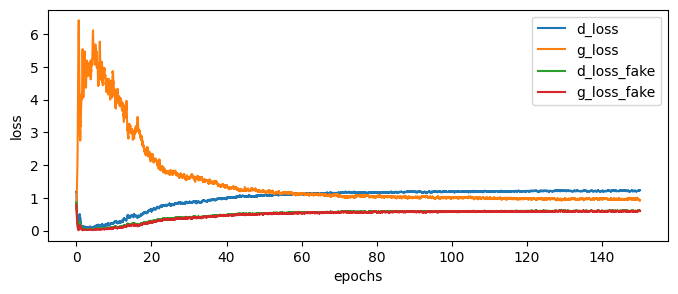

Epoch [151/200], Step[100/469], d_loss: 1.2162, d_loss_fake: 0.6174, g_loss: 0.9334, g_loss_fake: 0.6000, D(x): 0.58, D(G(z)): 0.44
Epoch [151/200], Step[200/469], d_loss: 1.2568, d_loss_fake: 0.6833, g_loss: 0.7773, g_loss_fake: 0.7321, D(x): 0.59, D(G(z)): 0.46
Epoch [151/200], Step[300/469], d_loss: 1.1637, d_loss_fake: 0.5907, g_loss: 0.9651, g_loss_fake: 0.5785, D(x): 0.60, D(G(z)): 0.42
Epoch [151/200], Step[400/469], d_loss: 1.2926, d_loss_fake: 0.7003, g_loss: 0.9944, g_loss_fake: 0.5648, D(x): 0.59, D(G(z)): 0.47
Epoch [152/200], Step[100/469], d_loss: 1.1855, d_loss_fake: 0.5494, g_loss: 0.9856, g_loss_fake: 0.5441, D(x): 0.57, D(G(z)): 0.40
Epoch [152/200], Step[200/469], d_loss: 1.1049, d_loss_fake: 0.5581, g_loss: 0.9239, g_loss_fake: 0.5893, D(x): 0.61, D(G(z)): 0.41
Epoch [152/200], Step[300/469], d_loss: 1.1813, d_loss_fake: 0.5905, g_loss: 0.8836, g_loss_fake: 0.6667, D(x): 0.59, D(G(z)): 0.42
Epoch [152/200], Step[400/469], d_loss: 1.2316, d_loss_fake: 0.6523, g_loss:

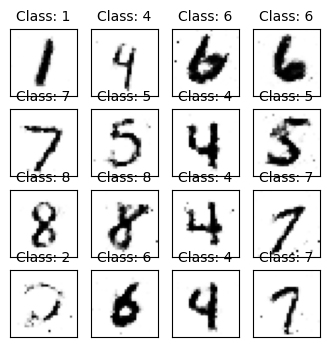

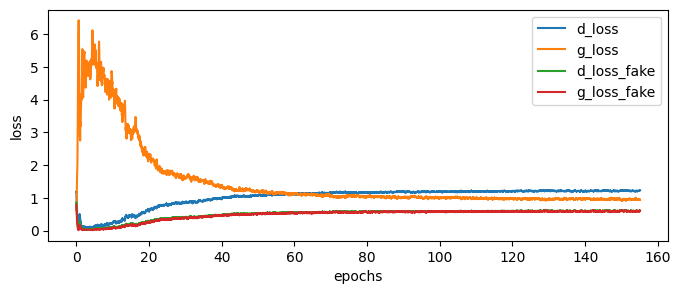

Epoch [156/200], Step[100/469], d_loss: 1.2508, d_loss_fake: 0.7532, g_loss: 0.8601, g_loss_fake: 0.6434, D(x): 0.64, D(G(z)): 0.50
Epoch [156/200], Step[200/469], d_loss: 1.2123, d_loss_fake: 0.5856, g_loss: 1.0051, g_loss_fake: 0.5633, D(x): 0.57, D(G(z)): 0.41
Epoch [156/200], Step[300/469], d_loss: 1.1366, d_loss_fake: 0.5529, g_loss: 1.0233, g_loss_fake: 0.5368, D(x): 0.59, D(G(z)): 0.40
Epoch [156/200], Step[400/469], d_loss: 1.2083, d_loss_fake: 0.5724, g_loss: 1.0252, g_loss_fake: 0.5596, D(x): 0.57, D(G(z)): 0.41
Epoch [157/200], Step[100/469], d_loss: 1.2105, d_loss_fake: 0.5367, g_loss: 0.9796, g_loss_fake: 0.5411, D(x): 0.55, D(G(z)): 0.40
Epoch [157/200], Step[200/469], d_loss: 1.1484, d_loss_fake: 0.5771, g_loss: 0.9290, g_loss_fake: 0.6277, D(x): 0.60, D(G(z)): 0.42
Epoch [157/200], Step[300/469], d_loss: 1.3388, d_loss_fake: 0.6330, g_loss: 0.9152, g_loss_fake: 0.6246, D(x): 0.53, D(G(z)): 0.42
Epoch [157/200], Step[400/469], d_loss: 1.3220, d_loss_fake: 0.6629, g_loss:

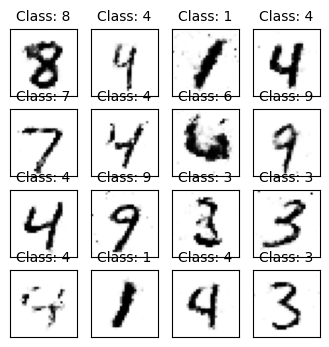

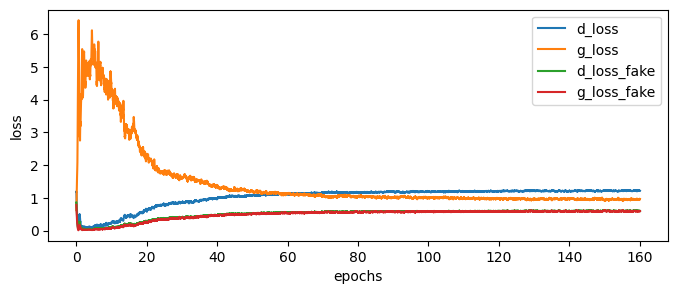

Epoch [161/200], Step[100/469], d_loss: 1.2256, d_loss_fake: 0.6788, g_loss: 0.9371, g_loss_fake: 0.6191, D(x): 0.61, D(G(z)): 0.45
Epoch [161/200], Step[200/469], d_loss: 1.2715, d_loss_fake: 0.6062, g_loss: 0.9306, g_loss_fake: 0.6040, D(x): 0.56, D(G(z)): 0.42
Epoch [161/200], Step[300/469], d_loss: 1.1673, d_loss_fake: 0.5108, g_loss: 0.9687, g_loss_fake: 0.6009, D(x): 0.55, D(G(z)): 0.38
Epoch [161/200], Step[400/469], d_loss: 1.2307, d_loss_fake: 0.6650, g_loss: 0.8397, g_loss_fake: 0.6798, D(x): 0.60, D(G(z)): 0.45
Epoch [162/200], Step[100/469], d_loss: 1.1991, d_loss_fake: 0.6068, g_loss: 0.9223, g_loss_fake: 0.6114, D(x): 0.59, D(G(z)): 0.43
Epoch [162/200], Step[200/469], d_loss: 1.2190, d_loss_fake: 0.6135, g_loss: 0.8520, g_loss_fake: 0.6647, D(x): 0.58, D(G(z)): 0.43
Epoch [162/200], Step[300/469], d_loss: 1.1980, d_loss_fake: 0.4848, g_loss: 1.1151, g_loss_fake: 0.5085, D(x): 0.53, D(G(z)): 0.36
Epoch [162/200], Step[400/469], d_loss: 1.1705, d_loss_fake: 0.5467, g_loss:

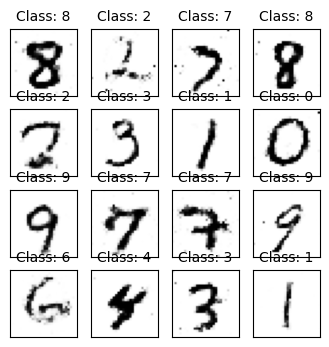

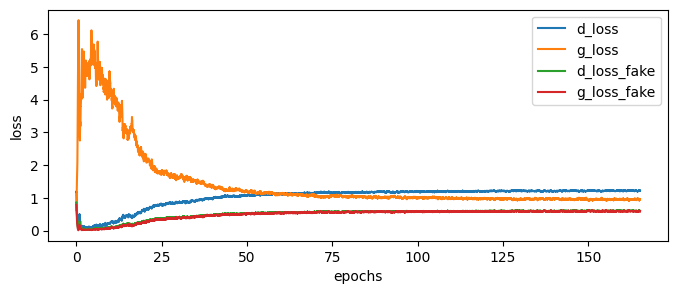

Epoch [166/200], Step[100/469], d_loss: 1.2448, d_loss_fake: 0.6366, g_loss: 0.8848, g_loss_fake: 0.6186, D(x): 0.57, D(G(z)): 0.45
Epoch [166/200], Step[200/469], d_loss: 1.2115, d_loss_fake: 0.5753, g_loss: 1.0312, g_loss_fake: 0.5724, D(x): 0.57, D(G(z)): 0.41
Epoch [166/200], Step[300/469], d_loss: 1.2030, d_loss_fake: 0.6044, g_loss: 0.9109, g_loss_fake: 0.5994, D(x): 0.59, D(G(z)): 0.43
Epoch [166/200], Step[400/469], d_loss: 1.2496, d_loss_fake: 0.6478, g_loss: 0.9452, g_loss_fake: 0.5866, D(x): 0.58, D(G(z)): 0.45
Epoch [167/200], Step[100/469], d_loss: 1.2501, d_loss_fake: 0.6562, g_loss: 0.9116, g_loss_fake: 0.6738, D(x): 0.59, D(G(z)): 0.44
Epoch [167/200], Step[200/469], d_loss: 1.2198, d_loss_fake: 0.5881, g_loss: 0.9422, g_loss_fake: 0.6030, D(x): 0.57, D(G(z)): 0.42
Epoch [167/200], Step[300/469], d_loss: 1.2280, d_loss_fake: 0.6343, g_loss: 0.9099, g_loss_fake: 0.6124, D(x): 0.59, D(G(z)): 0.44
Epoch [167/200], Step[400/469], d_loss: 1.2493, d_loss_fake: 0.6041, g_loss:

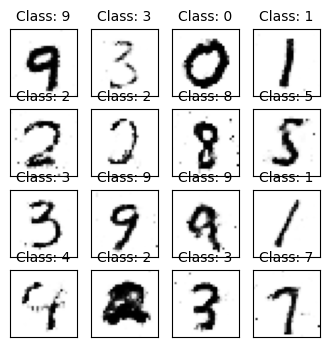

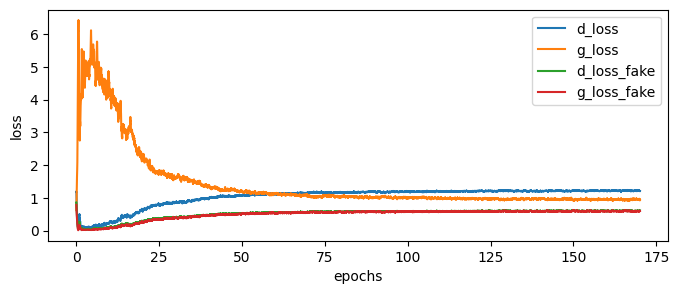

Epoch [171/200], Step[100/469], d_loss: 1.2382, d_loss_fake: 0.6424, g_loss: 1.0026, g_loss_fake: 0.5747, D(x): 0.59, D(G(z)): 0.43
Epoch [171/200], Step[200/469], d_loss: 1.2069, d_loss_fake: 0.6408, g_loss: 1.0318, g_loss_fake: 0.5719, D(x): 0.61, D(G(z)): 0.44
Epoch [171/200], Step[300/469], d_loss: 1.2662, d_loss_fake: 0.5743, g_loss: 1.0737, g_loss_fake: 0.5372, D(x): 0.52, D(G(z)): 0.41
Epoch [171/200], Step[400/469], d_loss: 1.1991, d_loss_fake: 0.5143, g_loss: 0.9760, g_loss_fake: 0.5903, D(x): 0.54, D(G(z)): 0.38
Epoch [172/200], Step[100/469], d_loss: 1.1799, d_loss_fake: 0.4593, g_loss: 1.0244, g_loss_fake: 0.5274, D(x): 0.53, D(G(z)): 0.34
Epoch [172/200], Step[200/469], d_loss: 1.2598, d_loss_fake: 0.5621, g_loss: 1.0047, g_loss_fake: 0.5820, D(x): 0.54, D(G(z)): 0.40
Epoch [172/200], Step[300/469], d_loss: 1.2630, d_loss_fake: 0.6116, g_loss: 0.9299, g_loss_fake: 0.6145, D(x): 0.56, D(G(z)): 0.42
Epoch [172/200], Step[400/469], d_loss: 1.2375, d_loss_fake: 0.5917, g_loss:

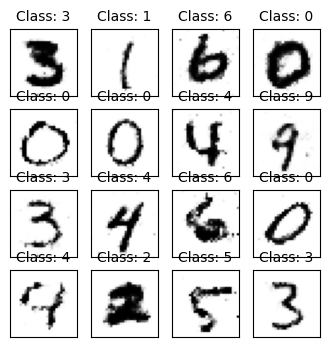

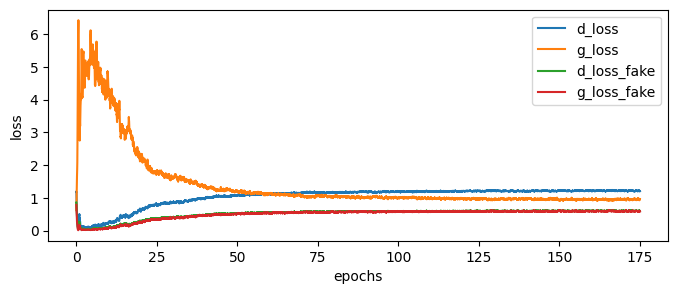

Epoch [176/200], Step[100/469], d_loss: 1.2983, d_loss_fake: 0.6332, g_loss: 0.9992, g_loss_fake: 0.5359, D(x): 0.55, D(G(z)): 0.44
Epoch [176/200], Step[200/469], d_loss: 1.1802, d_loss_fake: 0.6034, g_loss: 0.9367, g_loss_fake: 0.5869, D(x): 0.60, D(G(z)): 0.43
Epoch [176/200], Step[300/469], d_loss: 1.2799, d_loss_fake: 0.6903, g_loss: 0.9219, g_loss_fake: 0.6241, D(x): 0.59, D(G(z)): 0.46
Epoch [176/200], Step[400/469], d_loss: 1.2974, d_loss_fake: 0.6524, g_loss: 0.8694, g_loss_fake: 0.6560, D(x): 0.57, D(G(z)): 0.45
Epoch [177/200], Step[100/469], d_loss: 1.2213, d_loss_fake: 0.6611, g_loss: 0.9265, g_loss_fake: 0.6052, D(x): 0.60, D(G(z)): 0.45
Epoch [177/200], Step[200/469], d_loss: 1.2625, d_loss_fake: 0.6557, g_loss: 0.8772, g_loss_fake: 0.6747, D(x): 0.58, D(G(z)): 0.45
Epoch [177/200], Step[300/469], d_loss: 1.2081, d_loss_fake: 0.5881, g_loss: 0.9994, g_loss_fake: 0.5552, D(x): 0.57, D(G(z)): 0.42
Epoch [177/200], Step[400/469], d_loss: 1.2074, d_loss_fake: 0.5693, g_loss:

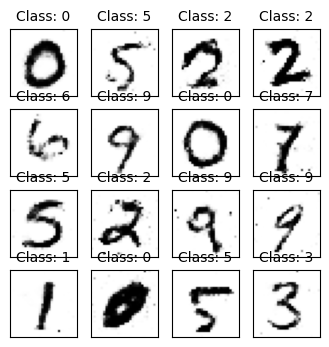

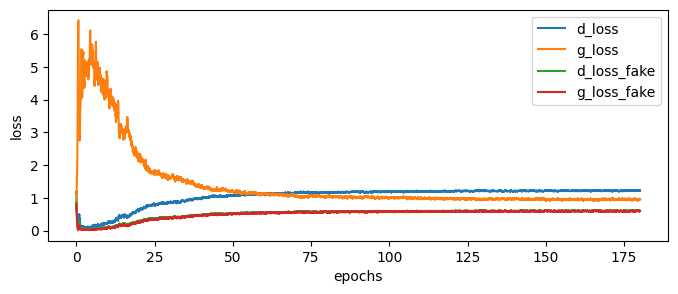

Epoch [181/200], Step[100/469], d_loss: 1.1181, d_loss_fake: 0.5934, g_loss: 0.9000, g_loss_fake: 0.6720, D(x): 0.63, D(G(z)): 0.42
Epoch [181/200], Step[200/469], d_loss: 1.1902, d_loss_fake: 0.5756, g_loss: 0.9405, g_loss_fake: 0.5899, D(x): 0.58, D(G(z)): 0.41
Epoch [181/200], Step[300/469], d_loss: 1.2289, d_loss_fake: 0.6175, g_loss: 0.8553, g_loss_fake: 0.6616, D(x): 0.58, D(G(z)): 0.44
Epoch [181/200], Step[400/469], d_loss: 1.3222, d_loss_fake: 0.6934, g_loss: 0.9298, g_loss_fake: 0.6113, D(x): 0.57, D(G(z)): 0.46
Epoch [182/200], Step[100/469], d_loss: 1.2279, d_loss_fake: 0.6228, g_loss: 1.0122, g_loss_fake: 0.5721, D(x): 0.58, D(G(z)): 0.43
Epoch [182/200], Step[200/469], d_loss: 1.1509, d_loss_fake: 0.5340, g_loss: 1.0187, g_loss_fake: 0.5260, D(x): 0.58, D(G(z)): 0.39
Epoch [182/200], Step[300/469], d_loss: 1.1835, d_loss_fake: 0.5759, g_loss: 0.9909, g_loss_fake: 0.5698, D(x): 0.58, D(G(z)): 0.41
Epoch [182/200], Step[400/469], d_loss: 1.1686, d_loss_fake: 0.4869, g_loss:

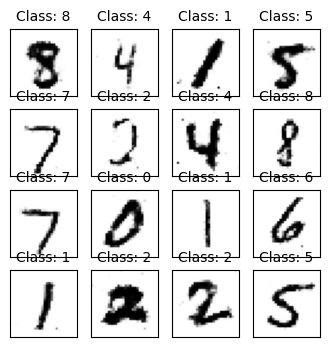

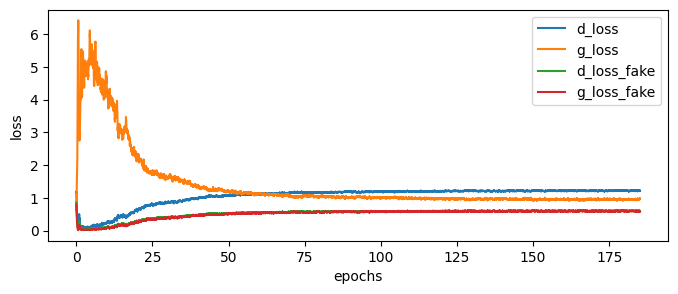

Epoch [186/200], Step[100/469], d_loss: 1.1693, d_loss_fake: 0.5507, g_loss: 1.0778, g_loss_fake: 0.4930, D(x): 0.57, D(G(z)): 0.40
Epoch [186/200], Step[200/469], d_loss: 1.2189, d_loss_fake: 0.5891, g_loss: 0.9010, g_loss_fake: 0.5972, D(x): 0.57, D(G(z)): 0.42
Epoch [186/200], Step[300/469], d_loss: 1.2229, d_loss_fake: 0.6552, g_loss: 0.7995, g_loss_fake: 0.7005, D(x): 0.59, D(G(z)): 0.46
Epoch [186/200], Step[400/469], d_loss: 1.1972, d_loss_fake: 0.5753, g_loss: 0.9707, g_loss_fake: 0.5984, D(x): 0.58, D(G(z)): 0.41
Epoch [187/200], Step[100/469], d_loss: 1.1630, d_loss_fake: 0.5122, g_loss: 1.0178, g_loss_fake: 0.5767, D(x): 0.56, D(G(z)): 0.38
Epoch [187/200], Step[200/469], d_loss: 1.2390, d_loss_fake: 0.6074, g_loss: 1.0309, g_loss_fake: 0.5422, D(x): 0.57, D(G(z)): 0.43
Epoch [187/200], Step[300/469], d_loss: 1.1854, d_loss_fake: 0.5855, g_loss: 0.9274, g_loss_fake: 0.6325, D(x): 0.58, D(G(z)): 0.42
Epoch [187/200], Step[400/469], d_loss: 1.2375, d_loss_fake: 0.6490, g_loss:

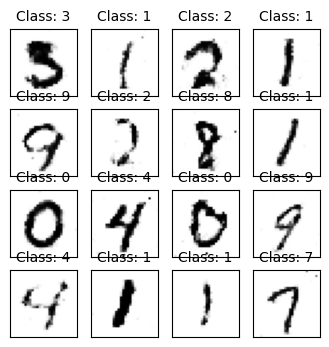

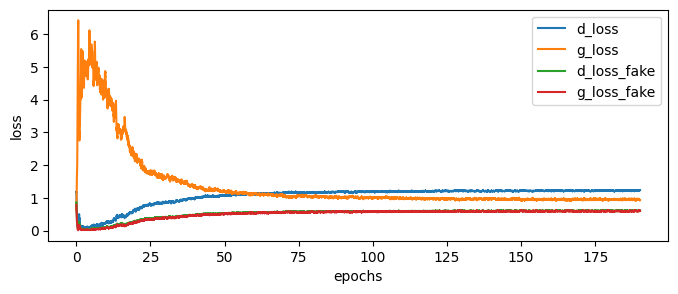

Epoch [191/200], Step[100/469], d_loss: 1.2275, d_loss_fake: 0.6303, g_loss: 1.0081, g_loss_fake: 0.5867, D(x): 0.59, D(G(z)): 0.44
Epoch [191/200], Step[200/469], d_loss: 1.2885, d_loss_fake: 0.6674, g_loss: 0.8309, g_loss_fake: 0.6822, D(x): 0.58, D(G(z)): 0.45
Epoch [191/200], Step[300/469], d_loss: 1.0784, d_loss_fake: 0.5233, g_loss: 1.0092, g_loss_fake: 0.6010, D(x): 0.60, D(G(z)): 0.38
Epoch [191/200], Step[400/469], d_loss: 1.2238, d_loss_fake: 0.6270, g_loss: 1.0332, g_loss_fake: 0.5369, D(x): 0.59, D(G(z)): 0.43
Epoch [192/200], Step[100/469], d_loss: 1.2455, d_loss_fake: 0.6290, g_loss: 0.9409, g_loss_fake: 0.6047, D(x): 0.58, D(G(z)): 0.44
Epoch [192/200], Step[200/469], d_loss: 1.2289, d_loss_fake: 0.6282, g_loss: 0.8558, g_loss_fake: 0.6377, D(x): 0.58, D(G(z)): 0.45
Epoch [192/200], Step[300/469], d_loss: 1.2026, d_loss_fake: 0.5778, g_loss: 1.0798, g_loss_fake: 0.4946, D(x): 0.57, D(G(z)): 0.42
Epoch [192/200], Step[400/469], d_loss: 1.2449, d_loss_fake: 0.5807, g_loss:

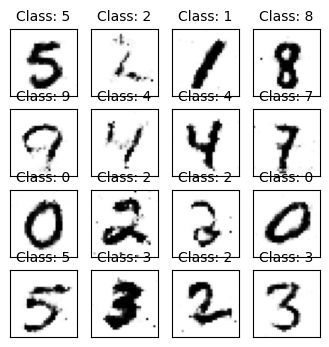

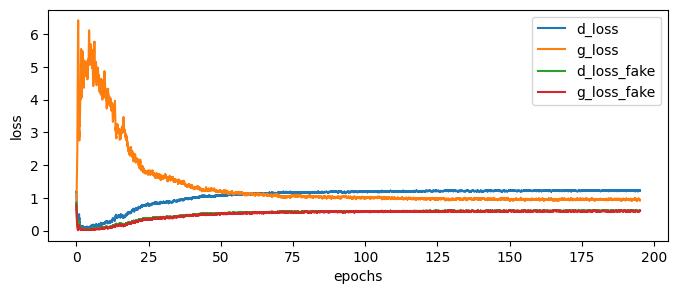

Epoch [196/200], Step[100/469], d_loss: 1.1562, d_loss_fake: 0.5271, g_loss: 0.9004, g_loss_fake: 0.5994, D(x): 0.57, D(G(z)): 0.39
Epoch [196/200], Step[200/469], d_loss: 1.1747, d_loss_fake: 0.5156, g_loss: 1.0896, g_loss_fake: 0.4872, D(x): 0.55, D(G(z)): 0.38
Epoch [196/200], Step[300/469], d_loss: 1.3257, d_loss_fake: 0.7201, g_loss: 0.8245, g_loss_fake: 0.6663, D(x): 0.57, D(G(z)): 0.49
Epoch [196/200], Step[400/469], d_loss: 1.1667, d_loss_fake: 0.6164, g_loss: 0.8386, g_loss_fake: 0.6749, D(x): 0.61, D(G(z)): 0.44
Epoch [197/200], Step[100/469], d_loss: 1.2115, d_loss_fake: 0.5884, g_loss: 0.8516, g_loss_fake: 0.6649, D(x): 0.57, D(G(z)): 0.43
Epoch [197/200], Step[200/469], d_loss: 1.1903, d_loss_fake: 0.5600, g_loss: 1.0848, g_loss_fake: 0.5081, D(x): 0.57, D(G(z)): 0.40
Epoch [197/200], Step[300/469], d_loss: 1.1728, d_loss_fake: 0.6056, g_loss: 0.8797, g_loss_fake: 0.6552, D(x): 0.60, D(G(z)): 0.43
Epoch [197/200], Step[400/469], d_loss: 1.1304, d_loss_fake: 0.5932, g_loss:

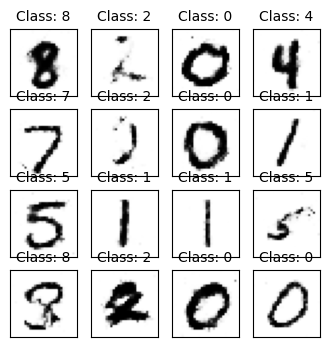

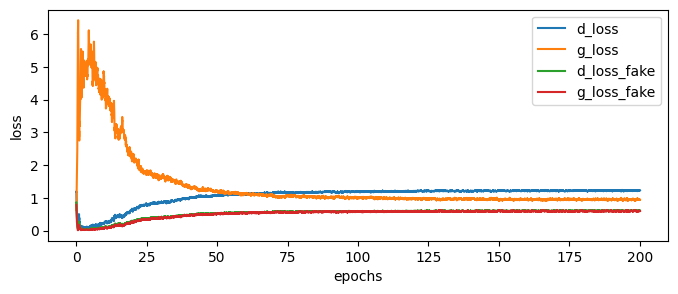

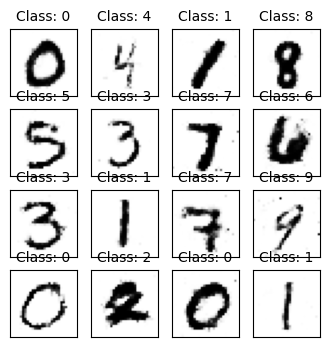

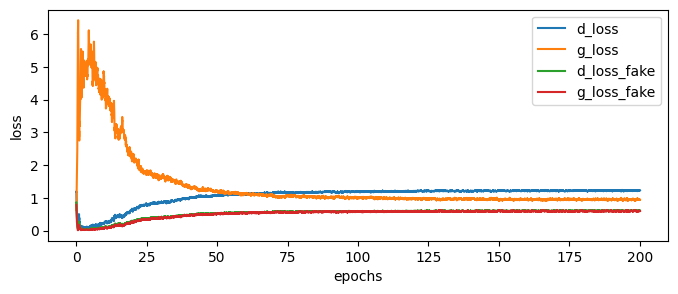

In [10]:
num_epochs = 200
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)